# 2. Time based analysis

Conduct time-based analysis of user behavior, compare churned versus retained users over time.

In [1]:
import pandas as pd
import numpy as np
import pyarrow
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns

In [2]:
data = pd.read_parquet('train.parquet', engine = 'pyarrow')

In [3]:
churn_events = data[data['page'] == 'Cancellation Confirmation'][['userId', 'time']]
churn_events = churn_events.rename(columns={'time': 'churn_time'})

In [4]:
all_users = data['userId'].unique()
churned_users = churn_events['userId'].unique()
non_churn_users = [u for u in all_users if u not in churned_users]

In [5]:
bad_pages = ['Downgrade', 'Thumbs Down', 'Submit Downgrade', 'Roll Advert', 'Error', 'Submit Downgrade']
good_pages = ['Thumbs Up', 'Add to Playlist', 'Add Friend', 'Upgrade', 'Submit Upgrade']
help_pages = ['Help', 'About', 'Settings', 'Save Settings']

In [6]:
def quick_analysis(user_id):
    user_data = data[data['userId'] == user_id].copy()

    # Churned
    try:
        churn_time = churn_events.loc[churn_events['userId'] == user_id, 'churn_time'].iloc[0]
        user_data = user_data[user_data['time'] >= churn_time - timedelta(days=10)]
        user_data['days_before_churn'] = (churn_time - user_data['time']).dt.days
        user_data['churned'] = 1
        user_data['reference_date'] = churn_time
        
    # Not churned
    except (IndexError, KeyError):
        last_dataset_date = data['time'].max()
        user_data = user_data[user_data['time'] >= last_dataset_date - timedelta(days=10)]
        user_data['days_before_churn'] = (last_dataset_date - user_data['time']).dt.days
        user_data['churned'] = 0
        user_data['reference_date'] = last_dataset_date
    
    return user_data

In [7]:
sample_users = list(churned_users[:5]) + list(non_churn_users[:5])

for user in sample_users:
    user_data = quick_analysis(user)
    print(f'User {user} had {len(user_data)} "events".')

User 1749042 had 631 "events".
User 1222580 had 439 "events".
User 1385500 had 1060 "events".
User 1032628 had 287 "events".
User 1009070 had 414 "events".
User 1563081 had 0 "events".
User 1697168 had 862 "events".
User 1714398 had 304 "events".
User 1010522 had 270 "events".
User 1475659 had 259 "events".


In [8]:
def analyze_activity_pattern(user_data):
    
    user_data = user_data.copy()
 
    daily_activity = user_data.groupby('days_before_churn').agg(
    total_events=('page', 'count'),
    songs_played=('page', lambda x: (x == 'NextSong').sum()),
    likes=('page', lambda x: (x == 'Thumbs Up').sum()),
    dislikes=('page', lambda x: (x == 'Thumbs Down').sum()),
    errors=('page', lambda x: (x == 'Error').sum()),
    ads=('page', lambda x: (x == 'Roll Advert').sum()),
    help_about=('page', lambda x: x.isin(help_pages).sum()),
    good_events=('page', lambda x: x.isin(good_pages).sum()),
    bad_events=('page', lambda x: x.isin(bad_pages).sum())
    )
    
    return daily_activity

In [9]:
sample_churner = sample_users[0]
data_churner = quick_analysis(sample_churner)
sample_churner1 = sample_users[1]
data_churner1 = quick_analysis(sample_churner1)
sample_non_churner = sample_users[-1]
data_non_churner = quick_analysis(sample_non_churner)
sample_non_churner1 = sample_users[-2]
data_non_churner1 = quick_analysis(sample_non_churner1)

In [10]:
analyze_activity_pattern(data_churner)

,total_events,songs_played,likes,dislikes,errors,ads,help_about,good_events,bad_events
days_before_churn,,,,,,,,,
0,61,43,3,0,0,0,4,5,2
1,33,27,2,0,0,0,1,2,1
7,230,195,6,0,0,0,3,18,2
8,225,187,12,1,0,0,7,24,4
9,82,68,5,1,0,0,3,9,1


In [11]:
analyze_activity_pattern(data_churner1)

,total_events,songs_played,likes,dislikes,errors,ads,help_about,good_events,bad_events
days_before_churn,,,,,,,,,
0,179,143,8,0,1,1,5,16,3
2,140,117,6,0,0,0,1,15,0
3,61,47,3,0,0,3,0,8,3
5,59,50,0,0,0,5,2,0,5


In [12]:
analyze_activity_pattern(data_non_churner)

,total_events,songs_played,likes,dislikes,errors,ads,help_about,good_events,bad_events
days_before_churn,,,,,,,,,
3,259,218,11,4,0,0,5,19,5


In [13]:
analyze_activity_pattern(data_non_churner1)

,total_events,songs_played,likes,dislikes,errors,ads,help_about,good_events,bad_events
days_before_churn,,,,,,,,,
2,28,23,0,0,0,4,0,1,4
4,33,22,2,0,0,4,0,4,4
5,77,66,0,0,0,3,3,1,3
6,91,65,5,1,0,2,3,12,3
7,1,1,0,0,0,0,0,0,0
9,40,33,1,1,0,2,0,3,3


In [14]:
def activity_analysis(user_data):
    user_data = user_data.copy()

    if len(user_data) == 0:
        results = {
            'userId': None,
            'num_sessions': 0,
            'total_songs_played': 0,
            'days_active': 0,
            'avg_songs_per_session': 0,
            'avg_time_between_sessions_seconds': None
        }
        return pd.DataFrame([results])
    
    daily_results = {}

    daily_results['userId'] = user_data['userId'].iloc[0]
    daily_results['num_sessions'] = user_data['sessionId'].nunique()
    daily_results['total_songs_played'] = (user_data['page'] == 'NextSong').sum()
    daily_results['days_active'] = user_data['time'].dt.date.nunique()

    if daily_results['num_sessions'] > 0:
        songs_per_session = []
        for session_id, session_data in user_data.groupby('sessionId'):
            songs_per_session.append((session_data['page'] == 'NextSong').sum())
        daily_results['avg_songs_per_session'] = np.mean(songs_per_session).round(2)
    else:
        daily_results['avg_songs_per_session'] = 0

    session_starts = []
    for session_id, session_data in user_data.groupby('sessionId'):
        session_starts.append(session_data['time'].min())
    if len(session_starts) > 1:
        session_starts_sorted = sorted(session_starts)
        time_between_sessions = []
        for i in range(len(session_starts_sorted) - 1):
            time_diff = (session_starts_sorted[i+1] - session_starts_sorted[i]).total_seconds()
            time_between_sessions.append(time_diff)
        daily_results['avg_time_between_sessions_seconds'] = np.mean(time_between_sessions).round(2)
    else:
        daily_results['avg_time_between_sessions_seconds'] = None

    
    return pd.DataFrame([daily_results])

In [15]:
activity_analysis(data_churner)

,userId,num_sessions,total_songs_played,days_active,avg_songs_per_session,avg_time_between_sessions_seconds
0,1749042,4,520,6,130.0,283854.67


In [16]:
activity_analysis(data_churner1)

,userId,num_sessions,total_songs_played,days_active,avg_songs_per_session,avg_time_between_sessions_seconds
0,1222580,4,357,4,89.25,139668.67


In [17]:
activity_analysis(data_non_churner)

,userId,num_sessions,total_songs_played,days_active,avg_songs_per_session,avg_time_between_sessions_seconds
0,1475659,1,218,1,218.0,None


In [18]:
activity_analysis(data_non_churner1)

,userId,num_sessions,total_songs_played,days_active,avg_songs_per_session,avg_time_between_sessions_seconds
0,1010522,6,210,6,35.0,128301.4


In [19]:
def analyze_activity_multiple_users(n_churners=50, n_non_churners=50):
    churner_ids = churned_users[:n_churners]
    non_churner_ids = non_churn_users[:n_non_churners]
    user_ids = list(churner_ids) + list(non_churner_ids)
    
    all_results = []
    
    for user_id in user_ids:
        user_data = quick_analysis(user_id)
        
        results = {'userId': user_id}
        results['churned'] = 1 if user_id in churner_ids else 0
        
        if len(user_data) == 0:
            results.update({
                'num_sessions': 0,
                'total_songs_played': 0,
                'days_active': 0,
                'avg_songs_per_session': 0,
                'avg_time_between_sessions_seconds': None,
                'songs_per_day': 0,
                'sessions_per_day': 0
            })
        else:
            results['num_sessions'] = user_data['sessionId'].nunique()
            results['total_songs_played'] = (user_data['page'] == 'NextSong').sum()
            results['days_active'] = user_data['time'].dt.date.nunique()
            
            if results['num_sessions'] > 0:
                songs_per_session = user_data[user_data['page'] == 'NextSong'].groupby('sessionId').size()
                results['avg_songs_per_session'] = songs_per_session.mean()
            else:
                results['avg_songs_per_session'] = 0
            
            if results['num_sessions'] > 1:
                session_starts = user_data.groupby('sessionId')['time'].min().sort_values()
                time_between = session_starts.diff().dropna().dt.total_seconds()
                results['avg_time_between_sessions_seconds'] = time_between.mean()
            else:
                results['avg_time_between_sessions_seconds'] = None
            
            if results['days_active'] > 0:
                results['songs_per_day'] = results['total_songs_played'] / results['days_active']
                results['sessions_per_day'] = results['num_sessions'] / results['days_active']
            else:
                results['songs_per_day'] = 0
                results['sessions_per_day'] = 0
        
        all_results.append(pd.DataFrame([results]))
    
    if all_results:
        return pd.concat(all_results, ignore_index=True)
    return pd.DataFrame()

In [20]:
analyze_activity_multiple_users(10, 10)

C:\Users\ninaj\AppData\Local\Temp\ipykernel_19544\127245236.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_results, ignore_index=True)


,userId,churned,num_sessions,total_songs_played,days_active,avg_songs_per_session,avg_time_between_sessions_seconds,songs_per_day,sessions_per_day
0,1749042,1,4,520,6,130.000000,283854.666667,86.666667,0.666667
1,1222580,1,4,357,4,89.250000,139668.666667,89.250000,1.000000
2,1385500,1,4,905,7,226.250000,239384.000000,129.285714,0.571429
3,1032628,1,1,248,1,248.000000,NaN,248.000000,1.000000
4,1009070,1,2,362,2,181.000000,229591.000000,181.000000,1.000000
5,1144647,1,5,819,6,163.800000,204256.000000,136.500000,0.833333
6,1834381,1,2,153,2,76.500000,473699.000000,76.500000,1.000000
7,1240184,1,12,1157,9,96.416667,75840.272727,128.555556,1.333333
8,1063929,1,3,454,4,151.333333,288826.500000,113.500000,0.750000
9,1559837,1,9,993,10,110.333333,86620.250000,99.300000,0.900000


In [21]:
def analyze_page_visits_multiple_users(n_churners=10, n_non_churners=10):
    churner_ids = churned_users[:n_churners]    
    non_churner_ids = non_churn_users[:n_non_churners]
    user_ids = list(churner_ids) + list(non_churner_ids)
    
    all_results = []
    
    for user_id in user_ids:
        user_data = quick_analysis(user_id)
        
        results = {'userId': user_id}
        results['churned'] = 1 if user_id in churner_ids else 0
        
        if len(user_data) == 0:
            results.update({
                'count_thumbs_up': 0,
                'count_thumbs_down': 0,
                'count_add_friend': 0,
                'count_add_to_playlist': 0,
                'count_roll_advert': 0,
                'count_error': 0,
                'count_help': 0,
                'thumbs_down_to_up_ratio': 0,
                'visited_submit_downgrade': 0,
                'visited_settings': 0,
                'visited_save_settings': 0,
                'visited_about': 0,
                'total_bad_pages': 0,
                'total_good_pages': 0,
                'total_help_pages': 0
            })
        else:
            page_counts = user_data['page'].value_counts()
            
            results['count_thumbs_up'] = page_counts.get('Thumbs Up', 0)
            results['count_thumbs_down'] = page_counts.get('Thumbs Down', 0)
            results['count_add_friend'] = page_counts.get('Add Friend', 0)
            results['count_add_to_playlist'] = page_counts.get('Add to Playlist', 0)
            results['count_roll_advert'] = page_counts.get('Roll Advert', 0)
            results['count_error'] = page_counts.get('Error', 0)
            results['count_help'] = page_counts.get('Help', 0)
            
            if results['count_thumbs_up'] > 0:
                results['thumbs_down_to_up_ratio'] = results['count_thumbs_down'] / results['count_thumbs_up']
            else:
                results['thumbs_down_to_up_ratio'] = 0 if results['count_thumbs_down'] == 0 else float('inf')
            
            results['visited_submit_downgrade'] = int('Submit Downgrade' in user_data['page'].values)
            results['visited_settings'] = int('Settings' in user_data['page'].values)
            results['visited_save_settings'] = int('Save Settings' in user_data['page'].values)
            results['visited_about'] = int('About' in user_data['page'].values)
            
            results['total_bad_pages'] = user_data['page'].isin(bad_pages).sum()
            results['total_good_pages'] = user_data['page'].isin(good_pages).sum()
            results['total_help_pages'] = user_data['page'].isin(help_pages).sum()
        
        all_results.append(pd.DataFrame([results]))
    
    if all_results:
        return pd.concat(all_results, ignore_index=True)
    return pd.DataFrame()       



In [22]:
analyze_page_visits_multiple_users()

,userId,churned,count_thumbs_up,count_thumbs_down,count_add_friend,count_add_to_playlist,count_roll_advert,count_error,count_help,thumbs_down_to_up_ratio,visited_submit_downgrade,visited_settings,visited_save_settings,visited_about,total_bad_pages,total_good_pages,total_help_pages
0,1749042,1,28,2,11,19,0,0,7,0.071429,0,1,1,1,10,58,18
1,1222580,1,17,0,10,10,9,1,3,0.000000,0,1,0,1,11,39,8
2,1385500,1,40,5,19,30,1,1,4,0.125000,0,1,1,0,15,89,11
3,1032628,1,16,1,1,6,0,0,1,0.062500,0,0,0,0,4,23,1
4,1009070,1,13,4,7,10,1,0,4,0.307692,0,1,0,0,8,30,5
5,1144647,1,40,7,17,21,9,1,3,0.175000,1,1,1,1,25,81,11
6,1834381,1,9,1,2,4,0,1,0,0.111111,0,0,0,0,5,15,0
7,1240184,1,60,11,19,36,2,3,7,0.183333,0,1,1,1,31,115,19
8,1063929,1,15,5,10,12,0,0,4,0.333333,0,1,1,1,13,37,7
9,1559837,1,39,10,16,37,1,2,4,0.256410,0,1,1,1,25,92,17


In [23]:
def analyze_demographics_multiple_users(n_churners=10, n_non_churners=10):
    churner_ids = churned_users[:n_churners]
    non_churner_ids = non_churn_users[:n_non_churners]
    user_ids = list(churner_ids) + list(non_churner_ids)
    
    all_results = []
    
    for user_id in user_ids:
        user_data = quick_analysis(user_id)
        
        results = {'userId': user_id}
        results['churned'] = 1 if user_id in churner_ids else 0
        
        if len(user_data) == 0:
            results.update({
                'level': None,
                'gender': None,
                'days_since_registration': None,
                'is_paid': 0,
                'is_male': 0
            })
        else:
            user_full_data = data[data['userId'] == user_id]
            
            if len(user_full_data) > 0:
                results['level'] = user_full_data['level'].iloc[-1]
                results['gender'] = user_full_data['gender'].iloc[0]
                
                reg_date = pd.to_datetime(user_full_data['registration'].iloc[0])
                last_activity = user_full_data['time'].max()
                results['days_since_registration'] = (last_activity - reg_date).days
            else:
                results['level'] = None
                results['gender'] = None
                results['days_since_registration'] = None
            
            results['is_paid'] = 1 if results['level'] == 'paid' else 0
            results['is_male'] = 1 if results['gender'] == 'M' else 0
        
        all_results.append(pd.DataFrame([results]))
    
    if all_results:
        return pd.concat(all_results, ignore_index=True)
    return pd.DataFrame()

In [24]:
analyze_demographics_multiple_users()

,userId,churned,level,gender,days_since_registration,is_paid,is_male
0,1749042,1,paid,M,73,1,1
1,1222580,1,paid,M,75,1,1
2,1385500,1,paid,M,93,1,1
3,1032628,1,paid,F,9,1,0
4,1009070,1,paid,F,9,1,0
5,1144647,1,paid,M,49,1,1
6,1834381,1,paid,M,21,1,1
7,1240184,1,paid,M,56,1,1
8,1063929,1,paid,M,34,1,1
9,1559837,1,paid,F,22,1,0


In [25]:
def analyze_music_diversity_multiple_users(n_churners=10, n_non_churners=10):
    churner_ids = churned_users[:n_churners]
    non_churner_ids = non_churn_users[:n_non_churners]
    user_ids = list(churner_ids) + list(non_churner_ids)
    
    all_results = []
    
    for user_id in user_ids:
        user_data = quick_analysis(user_id)
        
        results = {'userId': user_id}
        results['churned'] = 1 if user_id in churner_ids else 0
        
        if len(user_data) == 0:
            results.update({
                'unique_artists': 0,
                'unique_songs': 0,
                'avg_song_length': 0,
                'top_artist_concentration': 0,
                'song_repeat_ratio': 0
            })
        else:
            song_plays = user_data[user_data['page'] == 'NextSong']
            
            if len(song_plays) > 0:
                results['unique_artists'] = song_plays['artist'].nunique()
                results['unique_songs'] = song_plays['song'].nunique()
                results['avg_song_length'] = song_plays['length'].mean()
                
                if results['unique_artists'] > 0:
                    top_artist_count = song_plays['artist'].value_counts().iloc[0]
                    results['top_artist_concentration'] = top_artist_count / len(song_plays)
                else:
                    results['top_artist_concentration'] = 0
                
                results['song_repeat_ratio'] = 1 - (results['unique_songs'] / len(song_plays))
            else:
                results['unique_artists'] = 0
                results['unique_songs'] = 0
                results['avg_song_length'] = 0
                results['top_artist_concentration'] = 0
                results['song_repeat_ratio'] = 0
        
        all_results.append(pd.DataFrame([results]))
    
    if all_results:
        return pd.concat(all_results, ignore_index=True)
    return pd.DataFrame()

In [26]:
analyze_music_diversity_multiple_users()

,userId,churned,unique_artists,unique_songs,avg_song_length,top_artist_concentration,song_repeat_ratio
0,1749042,1,452,502,250.036997,0.011538,0.034615
1,1222580,1,320,342,259.842400,0.016807,0.042017
2,1385500,1,702,845,254.183012,0.008840,0.066298
3,1032628,1,227,242,240.977032,0.016129,0.024194
4,1009070,1,328,354,246.390526,0.013812,0.022099
5,1144647,1,643,758,247.261890,0.015873,0.074481
6,1834381,1,148,151,251.648537,0.013072,0.013072
7,1240184,1,841,1048,247.343375,0.012965,0.094209
8,1063929,1,400,438,241.340998,0.008811,0.035242
9,1559837,1,760,925,251.094445,0.012085,0.068479


In [27]:
def analyze_session_quality_multiple_users(n_churners=10, n_non_churners=10):
    churner_ids = churned_users[:n_churners]
    non_churner_ids = non_churn_users[:n_non_churners]
    user_ids = list(churner_ids) + list(non_churner_ids)
    
    all_results = []
    
    for user_id in user_ids:
        user_data = quick_analysis(user_id)
        
        results = {'userId': user_id}
        results['churned'] = 1 if user_id in churner_ids else 0
        
        if len(user_data) == 0:
            results.update({
                'avg_session_duration_seconds': 0,
                'max_session_duration_seconds': 0,
                'total_session_time_seconds': 0,
                'avg_item_in_session': 0,
                'max_item_in_session': 0,
                'events_per_minute': 0
            })
        else:
            user_data = user_data.sort_values('time')
            
            session_durations = []
            avg_item_in_session = []
            max_item_in_session = []
            
            for session_id, session_data in user_data.groupby('sessionId'):
                session_start = session_data['time'].min()
                session_end = session_data['time'].max()
                session_duration = (session_end - session_start).total_seconds()
                session_durations.append(session_duration)
                
                if 'itemInSession' in session_data.columns:
                    avg_item_in_session.append(session_data['itemInSession'].mean())
                    max_item_in_session.append(session_data['itemInSession'].max())
            
            if session_durations:
                results['avg_session_duration_seconds'] = np.mean(session_durations)
                results['max_session_duration_seconds'] = np.max(session_durations)
                results['total_session_time_seconds'] = np.sum(session_durations)
            else:
                results['avg_session_duration_seconds'] = 0
                results['max_session_duration_seconds'] = 0
                results['total_session_time_seconds'] = 0
            
            if avg_item_in_session:
                results['avg_item_in_session'] = np.mean(avg_item_in_session)
                results['max_item_in_session'] = np.max(max_item_in_session)
            else:
                results['avg_item_in_session'] = 0
                results['max_item_in_session'] = 0
            
            if results['avg_session_duration_seconds'] > 0:
                total_events = len(user_data)
                results['events_per_minute'] = total_events / (results['total_session_time_seconds'] / 60)
            else:
                results['events_per_minute'] = 0
        
        all_results.append(pd.DataFrame([results]))
    
    if all_results:
        return pd.concat(all_results, ignore_index=True)
    return pd.DataFrame()

In [28]:
analyze_session_quality_multiple_users()

,userId,churned,avg_session_duration_seconds,max_session_duration_seconds,total_session_time_seconds,avg_item_in_session,max_item_in_session,events_per_minute
0,1749042,1,33138.000000,98069.0,132552.0,92.239622,463,0.285624
1,1222580,1,22960.500000,36945.0,91842.0,54.904787,180,0.286797
2,1385500,1,57187.000000,80371.0,228748.0,135.294700,387,0.278035
3,1032628,1,59231.000000,59231.0,59231.0,444.498258,591,0.290726
4,1009070,1,44467.500000,83235.0,88935.0,206.178295,594,0.279305
5,1144647,1,40288.200000,116197.0,201441.0,98.587038,558,0.290408
6,1834381,1,19163.000000,28966.0,38326.0,139.000000,321,0.278662
7,1240184,1,23566.333333,82739.0,282796.0,58.935554,394,0.294488
8,1063929,1,36982.666667,68300.0,110948.0,90.141733,338,0.289866
9,1559837,1,27422.333333,82106.0,246801.0,66.854219,391,0.287114


In [29]:
def analyze_temporal_trends_multiple_users(n_churners=10, n_non_churners=10):
    churner_ids = churned_users[:n_churners]
    non_churner_ids = non_churn_users[:n_non_churners]
    user_ids = list(churner_ids) + list(non_churner_ids)
    
    all_results = []
    
    for user_id in user_ids:
        user_data = quick_analysis(user_id)
        
        results = {'userId': user_id}
        results['churned'] = 1 if user_id in churner_ids else 0
        
        if len(user_data) == 0:
            results.update({
                'songs_per_day_trend': 0,
                'sessions_per_day_trend': 0,
                'events_per_day_trend': 0,
                'songs_change_first_last': None,
                'sessions_change_first_last': None,
                'events_change_first_last': None,
                'songs_volatility': 0,
                'sessions_volatility': 0,
                'events_volatility': 0
            })
        else:
            user_data = user_data.sort_values('time')
            user_data['date'] = user_data['time'].dt.date
            
            daily_stats = user_data.groupby('date').agg(
                songs_played=('page', lambda x: (x == 'NextSong').sum()),
                sessions=('sessionId', 'nunique'),
                events=('page', 'count')
            ).reset_index()
            
            if len(daily_stats) > 1:
                daily_stats = daily_stats.sort_values('date')
                days = np.arange(len(daily_stats))
                
                songs = daily_stats['songs_played'].values
                if len(songs) > 1:
                    results['songs_per_day_trend'] = np.polyfit(days, songs, 1)[0]
                else:
                    results['songs_per_day_trend'] = 0
                
                sessions = daily_stats['sessions'].values
                if len(sessions) > 1:
                    results['sessions_per_day_trend'] = np.polyfit(days, sessions, 1)[0]
                else:
                    results['sessions_per_day_trend'] = 0
                
                events = daily_stats['events'].values
                if len(events) > 1:
                    results['events_per_day_trend'] = np.polyfit(days, events, 1)[0]
                else:
                    results['events_per_day_trend'] = 0
                
                if len(daily_stats) >= 10:
                    first_half = daily_stats.iloc[:5]
                    second_half = daily_stats.iloc[-5:]
                    
                    results['songs_change_first_last'] = second_half['songs_played'].mean() - first_half['songs_played'].mean()
                    results['sessions_change_first_last'] = second_half['sessions'].mean() - first_half['sessions'].mean()
                    results['events_change_first_last'] = second_half['events'].mean() - first_half['events'].mean()
                else:
                    results['songs_change_first_last'] = None
                    results['sessions_change_first_last'] = None
                    results['events_change_first_last'] = None
                
                results['songs_volatility'] = np.std(songs) if len(songs) > 1 else 0
                results['sessions_volatility'] = np.std(sessions) if len(sessions) > 1 else 0
                results['events_volatility'] = np.std(events) if len(events) > 1 else 0
            else:
                results['songs_per_day_trend'] = 0
                results['sessions_per_day_trend'] = 0
                results['events_per_day_trend'] = 0
                results['songs_change_first_last'] = None
                results['sessions_change_first_last'] = None
                results['events_change_first_last'] = None
                results['songs_volatility'] = 0
                results['sessions_volatility'] = 0
                results['events_volatility'] = 0
        
        all_results.append(pd.DataFrame([results]))
    
    if all_results:
        return pd.concat(all_results, ignore_index=True)
    return pd.DataFrame()

In [30]:
analyze_temporal_trends_multiple_users()

C:\Users\ninaj\AppData\Local\Temp\ipykernel_19544\2663843315.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_results, ignore_index=True)


,userId,churned,songs_per_day_trend,sessions_per_day_trend,events_per_day_trend,songs_change_first_last,sessions_change_first_last,events_change_first_last,songs_volatility,sessions_volatility,events_volatility
0,1749042,1,-25.142857,-5.988098e-17,-28.771429,NaN,NaN,NaN,76.593443,0.000000,89.232686
1,1222580,1,32.700000,-1.000000e-01,41.100000,NaN,NaN,NaN,37.705272,0.433013,47.017949
2,1385500,1,-26.892857,-7.142857e-02,-32.357143,NaN,NaN,NaN,78.096487,0.349927,92.584876
3,1032628,1,0.000000,0.000000e+00,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
4,1009070,1,-316.000000,-1.110223e-16,-360.000000,NaN,NaN,NaN,158.000000,0.000000,180.000000
5,1144647,1,-7.114286,-5.988098e-17,-9.514286,NaN,NaN,NaN,89.220233,0.000000,101.241872
6,1834381,1,-77.000000,-1.110223e-16,-86.000000,NaN,NaN,NaN,38.500000,0.000000,43.000000
7,1240184,1,8.216667,1.666667e-02,9.383333,NaN,NaN,NaN,106.408136,0.496904,125.796818
8,1063929,1,38.000000,-1.186878e-16,43.800000,NaN,NaN,NaN,51.188378,0.000000,59.937467
9,1559837,1,16.987879,8.484848e-02,20.648485,43.8,0.4,57.0,85.216254,0.489898,100.148340


In [31]:
def analyze_all_features_multiple_users(n_churners=10, n_non_churners=10):

    activity_df = analyze_activity_multiple_users(n_churners, n_non_churners)
    page_df = analyze_page_visits_multiple_users(n_churners, n_non_churners)
    demo_df = analyze_demographics_multiple_users(n_churners, n_non_churners)
    music_df = analyze_music_diversity_multiple_users(n_churners, n_non_churners)
    session_df = analyze_session_quality_multiple_users(n_churners, n_non_churners)
    trends_df = analyze_temporal_trends_multiple_users(n_churners, n_non_churners)
    
    all_features = activity_df.copy()
    
    for name, df in [("Page", page_df), ("Demo", demo_df), ("Music", music_df), 
                     ("Session", session_df), ("Trends", trends_df)]:
        if not df.empty and 'userId' in df.columns:
            cols_to_keep = [col for col in df.columns if col not in ['userId', 'churned']]
            if cols_to_keep:
                df_to_merge = df[['userId'] + cols_to_keep]
                all_features = pd.merge(all_features, df_to_merge, on='userId', how='left')
    
    return all_features

In [32]:
analyze_all_features_multiple_users()

C:\Users\ninaj\AppData\Local\Temp\ipykernel_19544\127245236.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_results, ignore_index=True)
C:\Users\ninaj\AppData\Local\Temp\ipykernel_19544\2663843315.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_results, ignore_index=True)


,userId,churned,num_sessions,total_songs_played,days_active,avg_songs_per_session,avg_time_between_sessions_seconds,songs_per_day,sessions_per_day,count_thumbs_up,...,events_per_minute,songs_per_day_trend,sessions_per_day_trend,events_per_day_trend,songs_change_first_last,sessions_change_first_last,events_change_first_last,songs_volatility,sessions_volatility,events_volatility
0,1749042,1,4,520,6,130.000000,283854.666667,86.666667,0.666667,28,...,0.285624,-25.142857,-5.988098e-17,-28.771429,NaN,NaN,NaN,76.593443,0.000000,89.232686
1,1222580,1,4,357,4,89.250000,139668.666667,89.250000,1.000000,17,...,0.286797,32.700000,-1.000000e-01,41.100000,NaN,NaN,NaN,37.705272,0.433013,47.017949
2,1385500,1,4,905,7,226.250000,239384.000000,129.285714,0.571429,40,...,0.278035,-26.892857,-7.142857e-02,-32.357143,NaN,NaN,NaN,78.096487,0.349927,92.584876
3,1032628,1,1,248,1,248.000000,NaN,248.000000,1.000000,16,...,0.290726,0.000000,0.000000e+00,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
4,1009070,1,2,362,2,181.000000,229591.000000,181.000000,1.000000,13,...,0.279305,-316.000000,-1.110223e-16,-360.000000,NaN,NaN,NaN,158.000000,0.000000,180.000000
5,1144647,1,5,819,6,163.800000,204256.000000,136.500000,0.833333,40,...,0.290408,-7.114286,-5.988098e-17,-9.514286,NaN,NaN,NaN,89.220233,0.000000,101.241872
6,1834381,1,2,153,2,76.500000,473699.000000,76.500000,1.000000,9,...,0.278662,-77.000000,-1.110223e-16,-86.000000,NaN,NaN,NaN,38.500000,0.000000,43.000000
7,1240184,1,12,1157,9,96.416667,75840.272727,128.555556,1.333333,60,...,0.294488,8.216667,1.666667e-02,9.383333,NaN,NaN,NaN,106.408136,0.496904,125.796818
8,1063929,1,3,454,4,151.333333,288826.500000,113.500000,0.750000,15,...,0.289866,38.000000,-1.186878e-16,43.800000,NaN,NaN,NaN,51.188378,0.000000,59.937467
9,1559837,1,9,993,10,110.333333,86620.250000,99.300000,0.900000,39,...,0.287114,16.987879,8.484848e-02,20.648485,43.8,0.4,57.0,85.216254,0.489898,100.148340


In [33]:
users_200 = analyze_all_features_multiple_users(100, 100)

C:\Users\ninaj\AppData\Local\Temp\ipykernel_19544\127245236.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_results, ignore_index=True)
C:\Users\ninaj\AppData\Local\Temp\ipykernel_19544\2663843315.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_results, ignore_index=True)


Features shape: (200, 49)
Churners: 100, Non-churners: {len(features_df) - features_df['churned'].sum()}

1. DISTRIBUTION PLOTS - Churners vs Non-Churners

Plotting Activity Metrics...


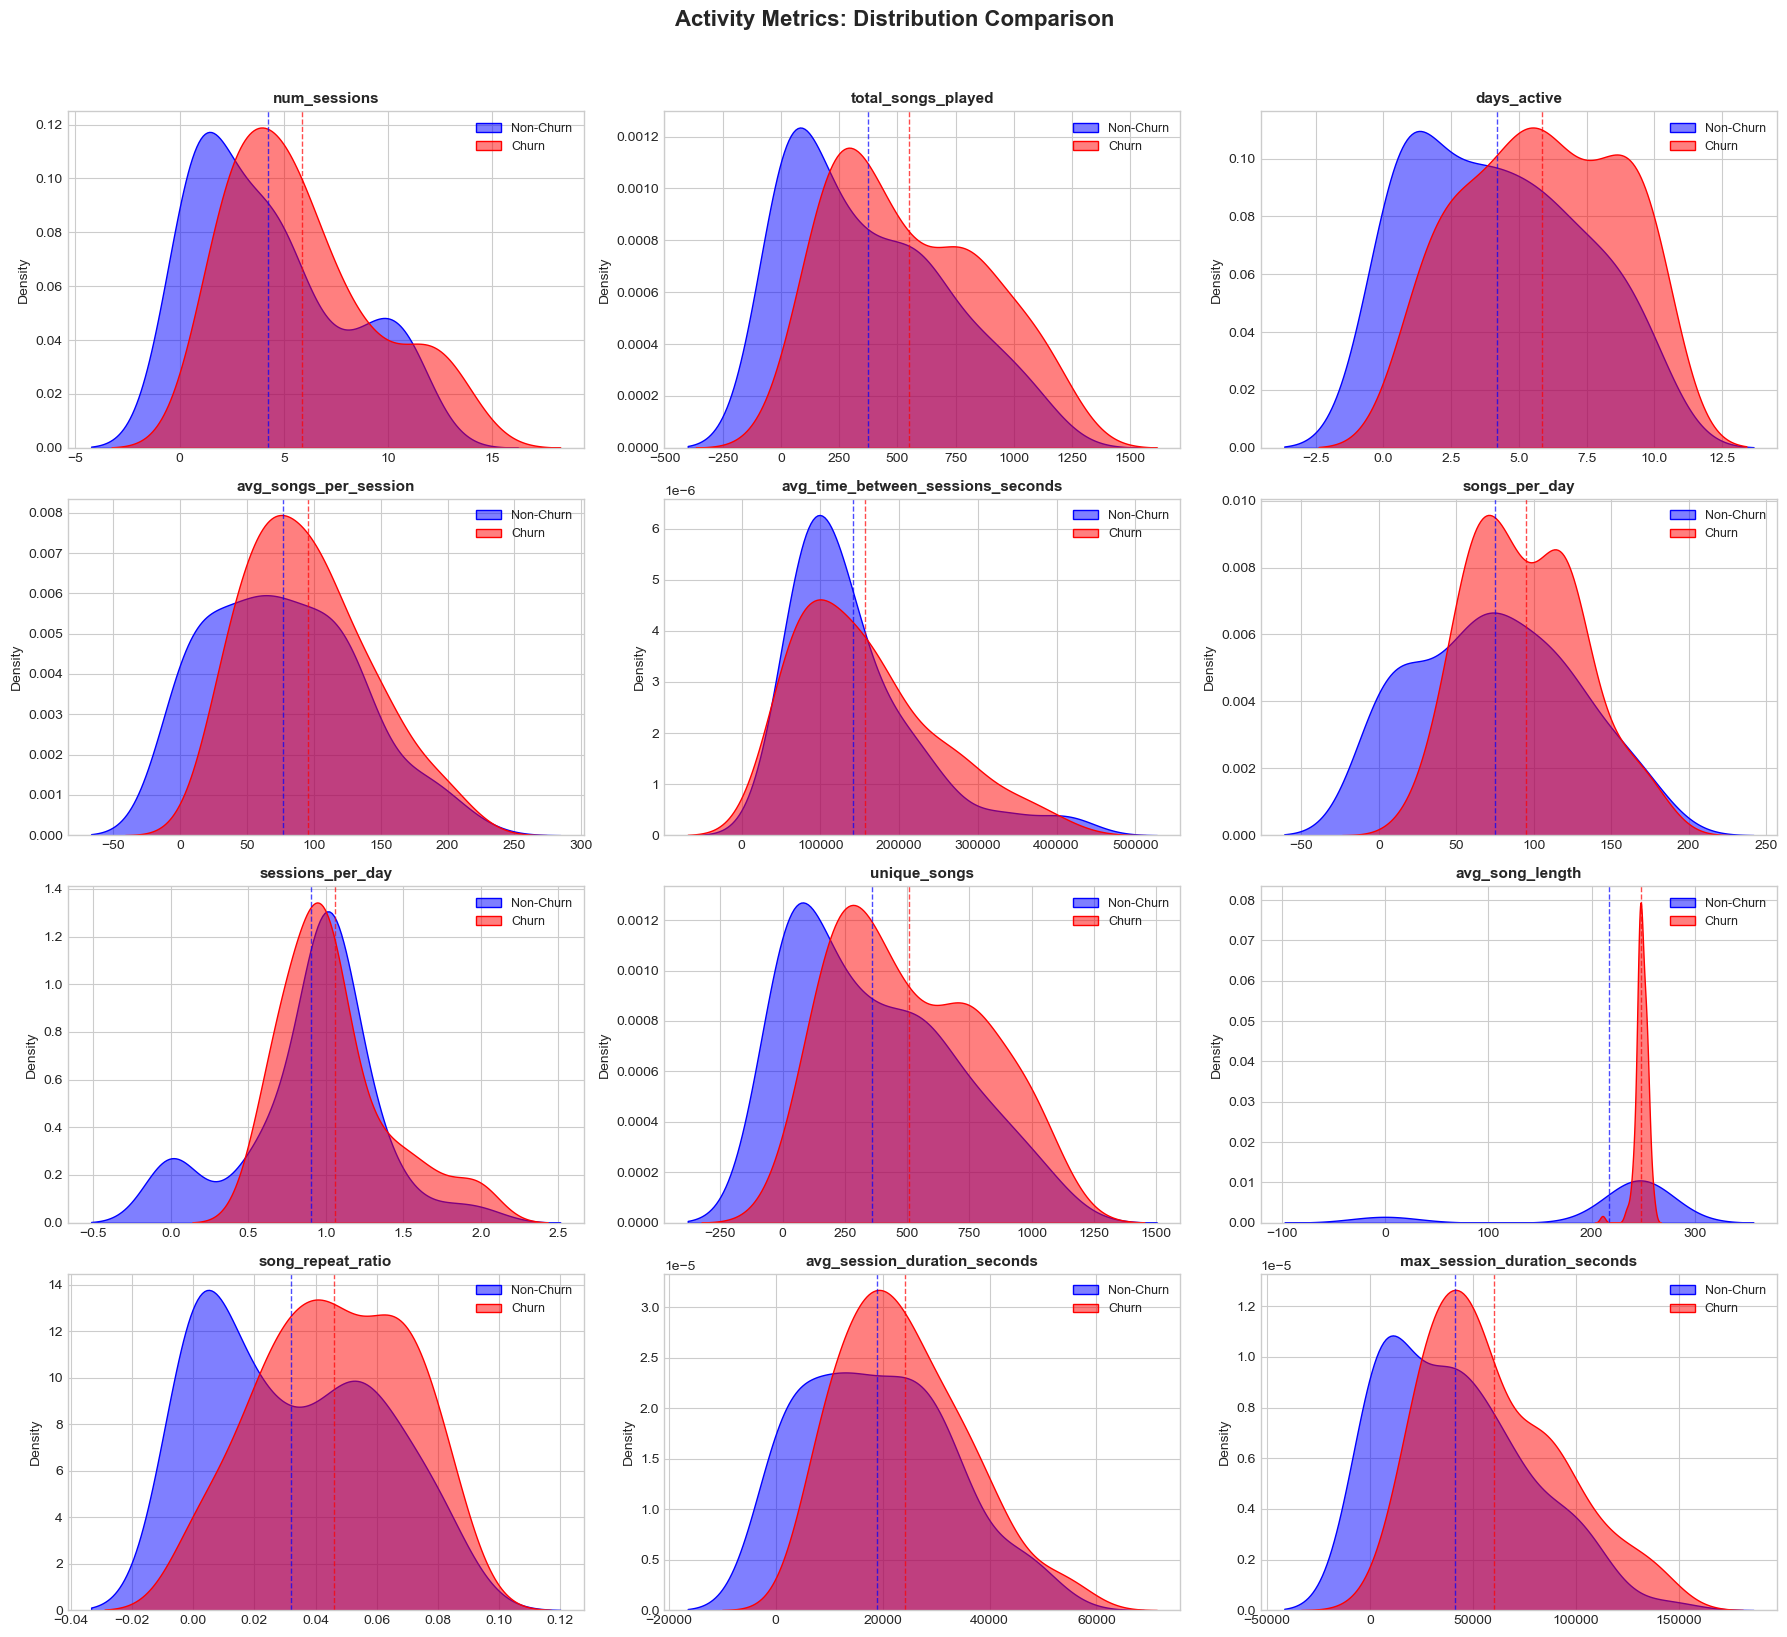


Plotting Page Visit Metrics...


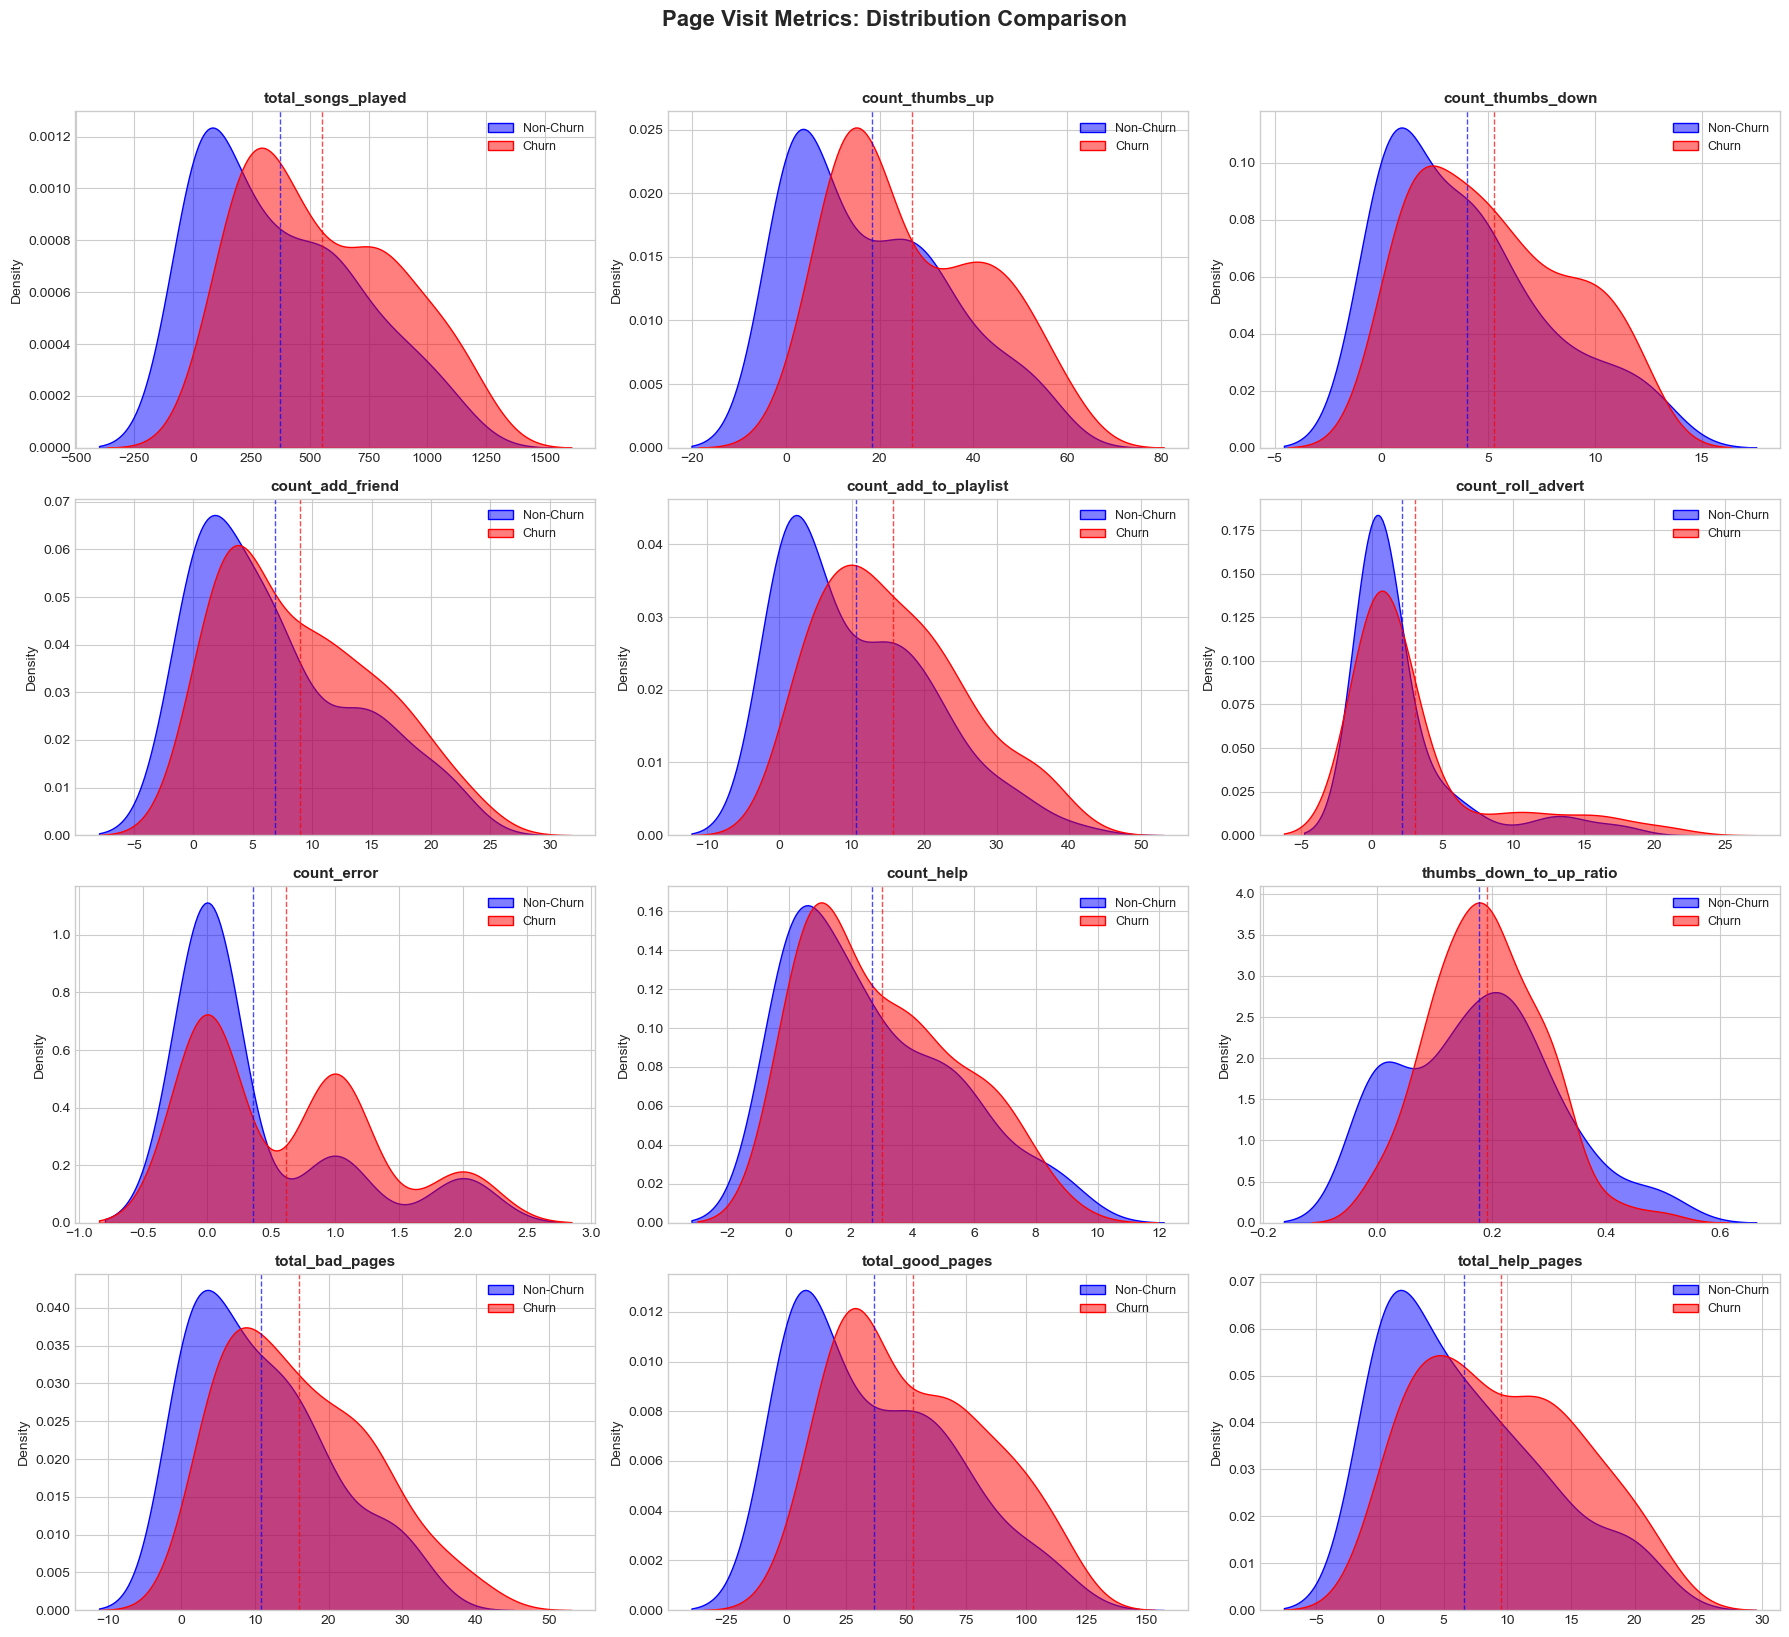


Plotting Music Diversity...


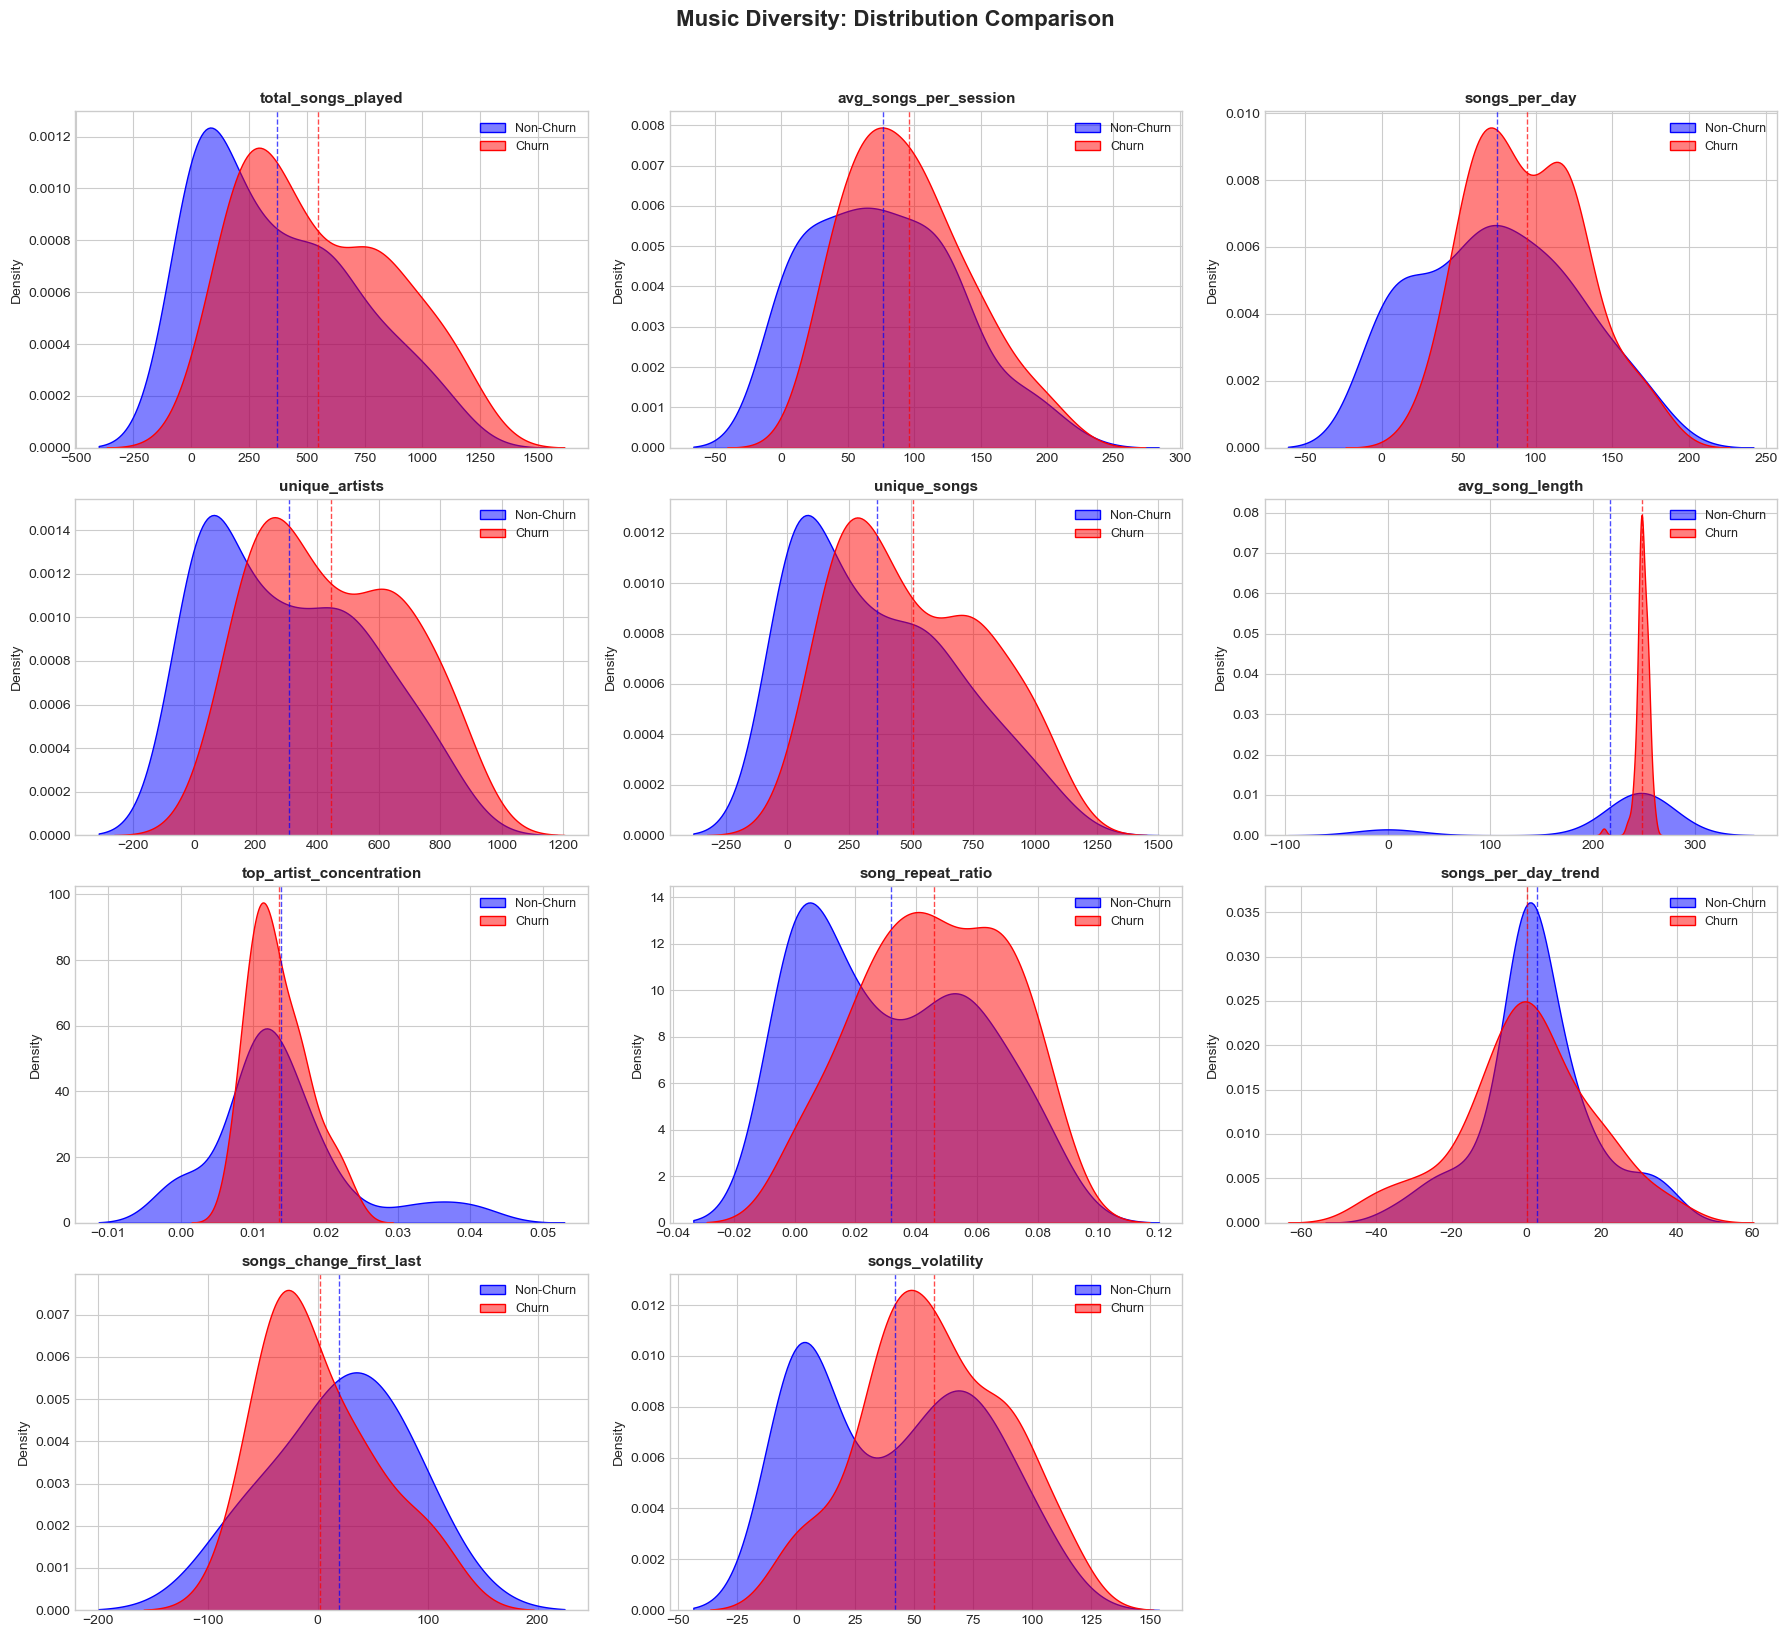


Plotting Time & Trends...


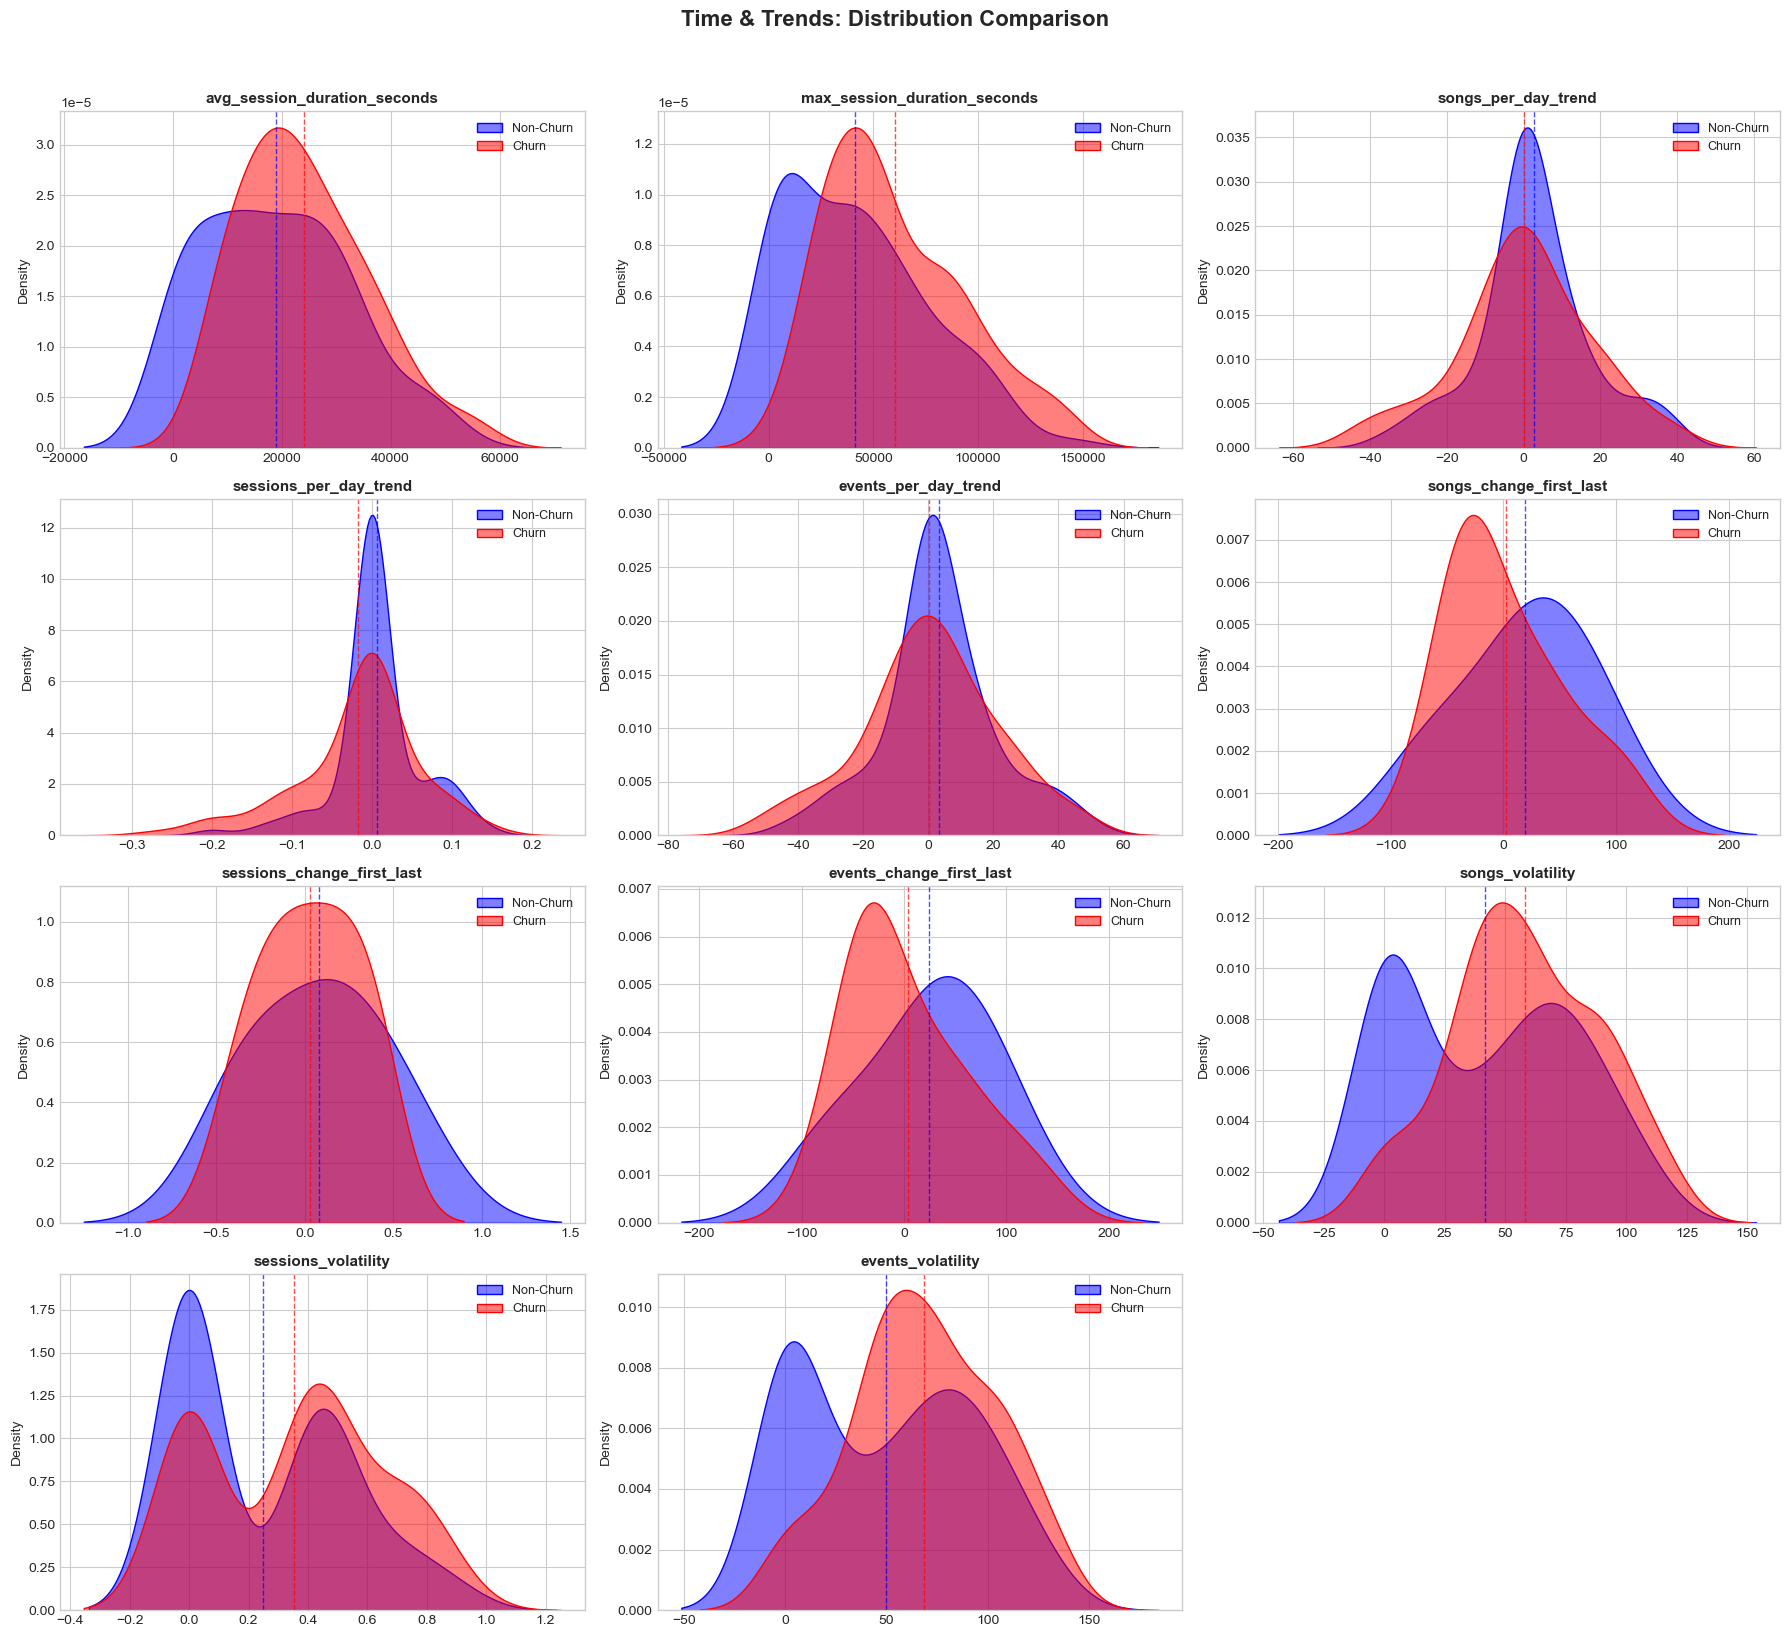


2. BOX PLOTS


C:\Users\ninaj\AppData\Local\Temp\ipykernel_19544\393062951.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churned_str', y=feature, data=features_df, ax=ax,
C:\Users\ninaj\AppData\Local\Temp\ipykernel_19544\393062951.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churned_str', y=feature, data=features_df, ax=ax,
C:\Users\ninaj\AppData\Local\Temp\ipykernel_19544\393062951.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churned_str', y=feature, data=features_df, ax=ax,
C:\Users\ninaj\AppData\Local\Temp\ipykernel_19

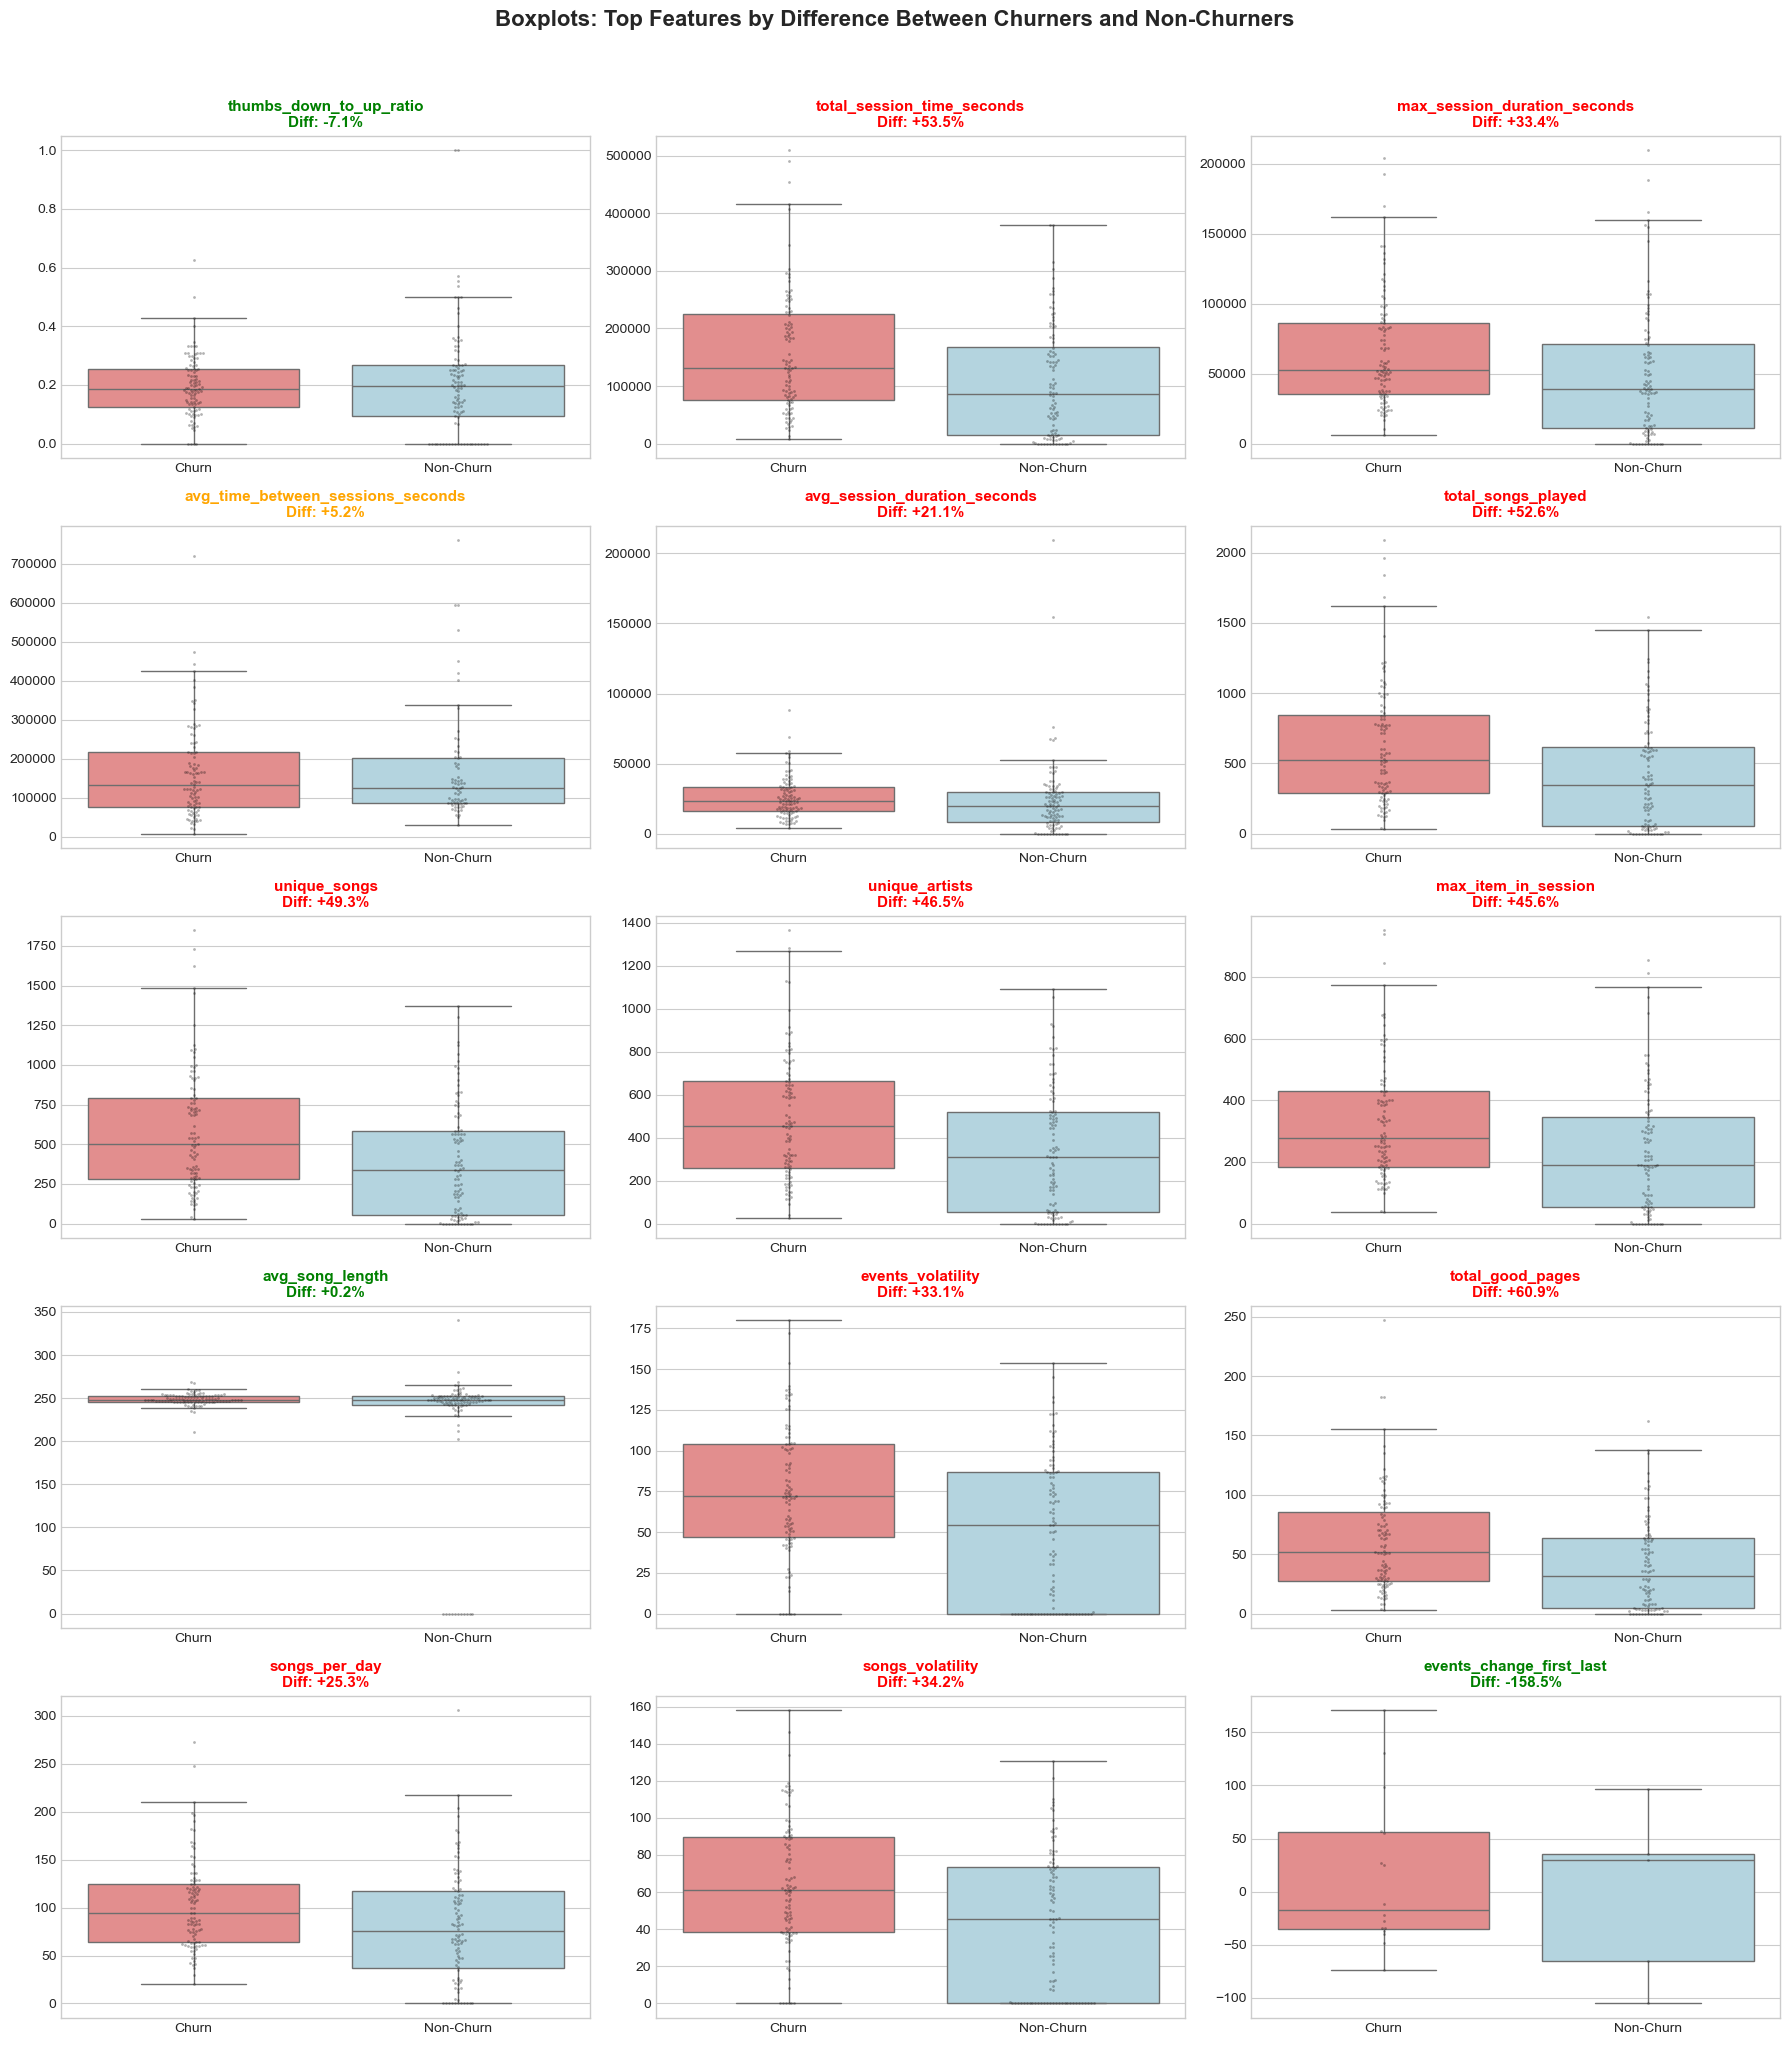


3. CATEGORICAL FEATURES - Bar Charts


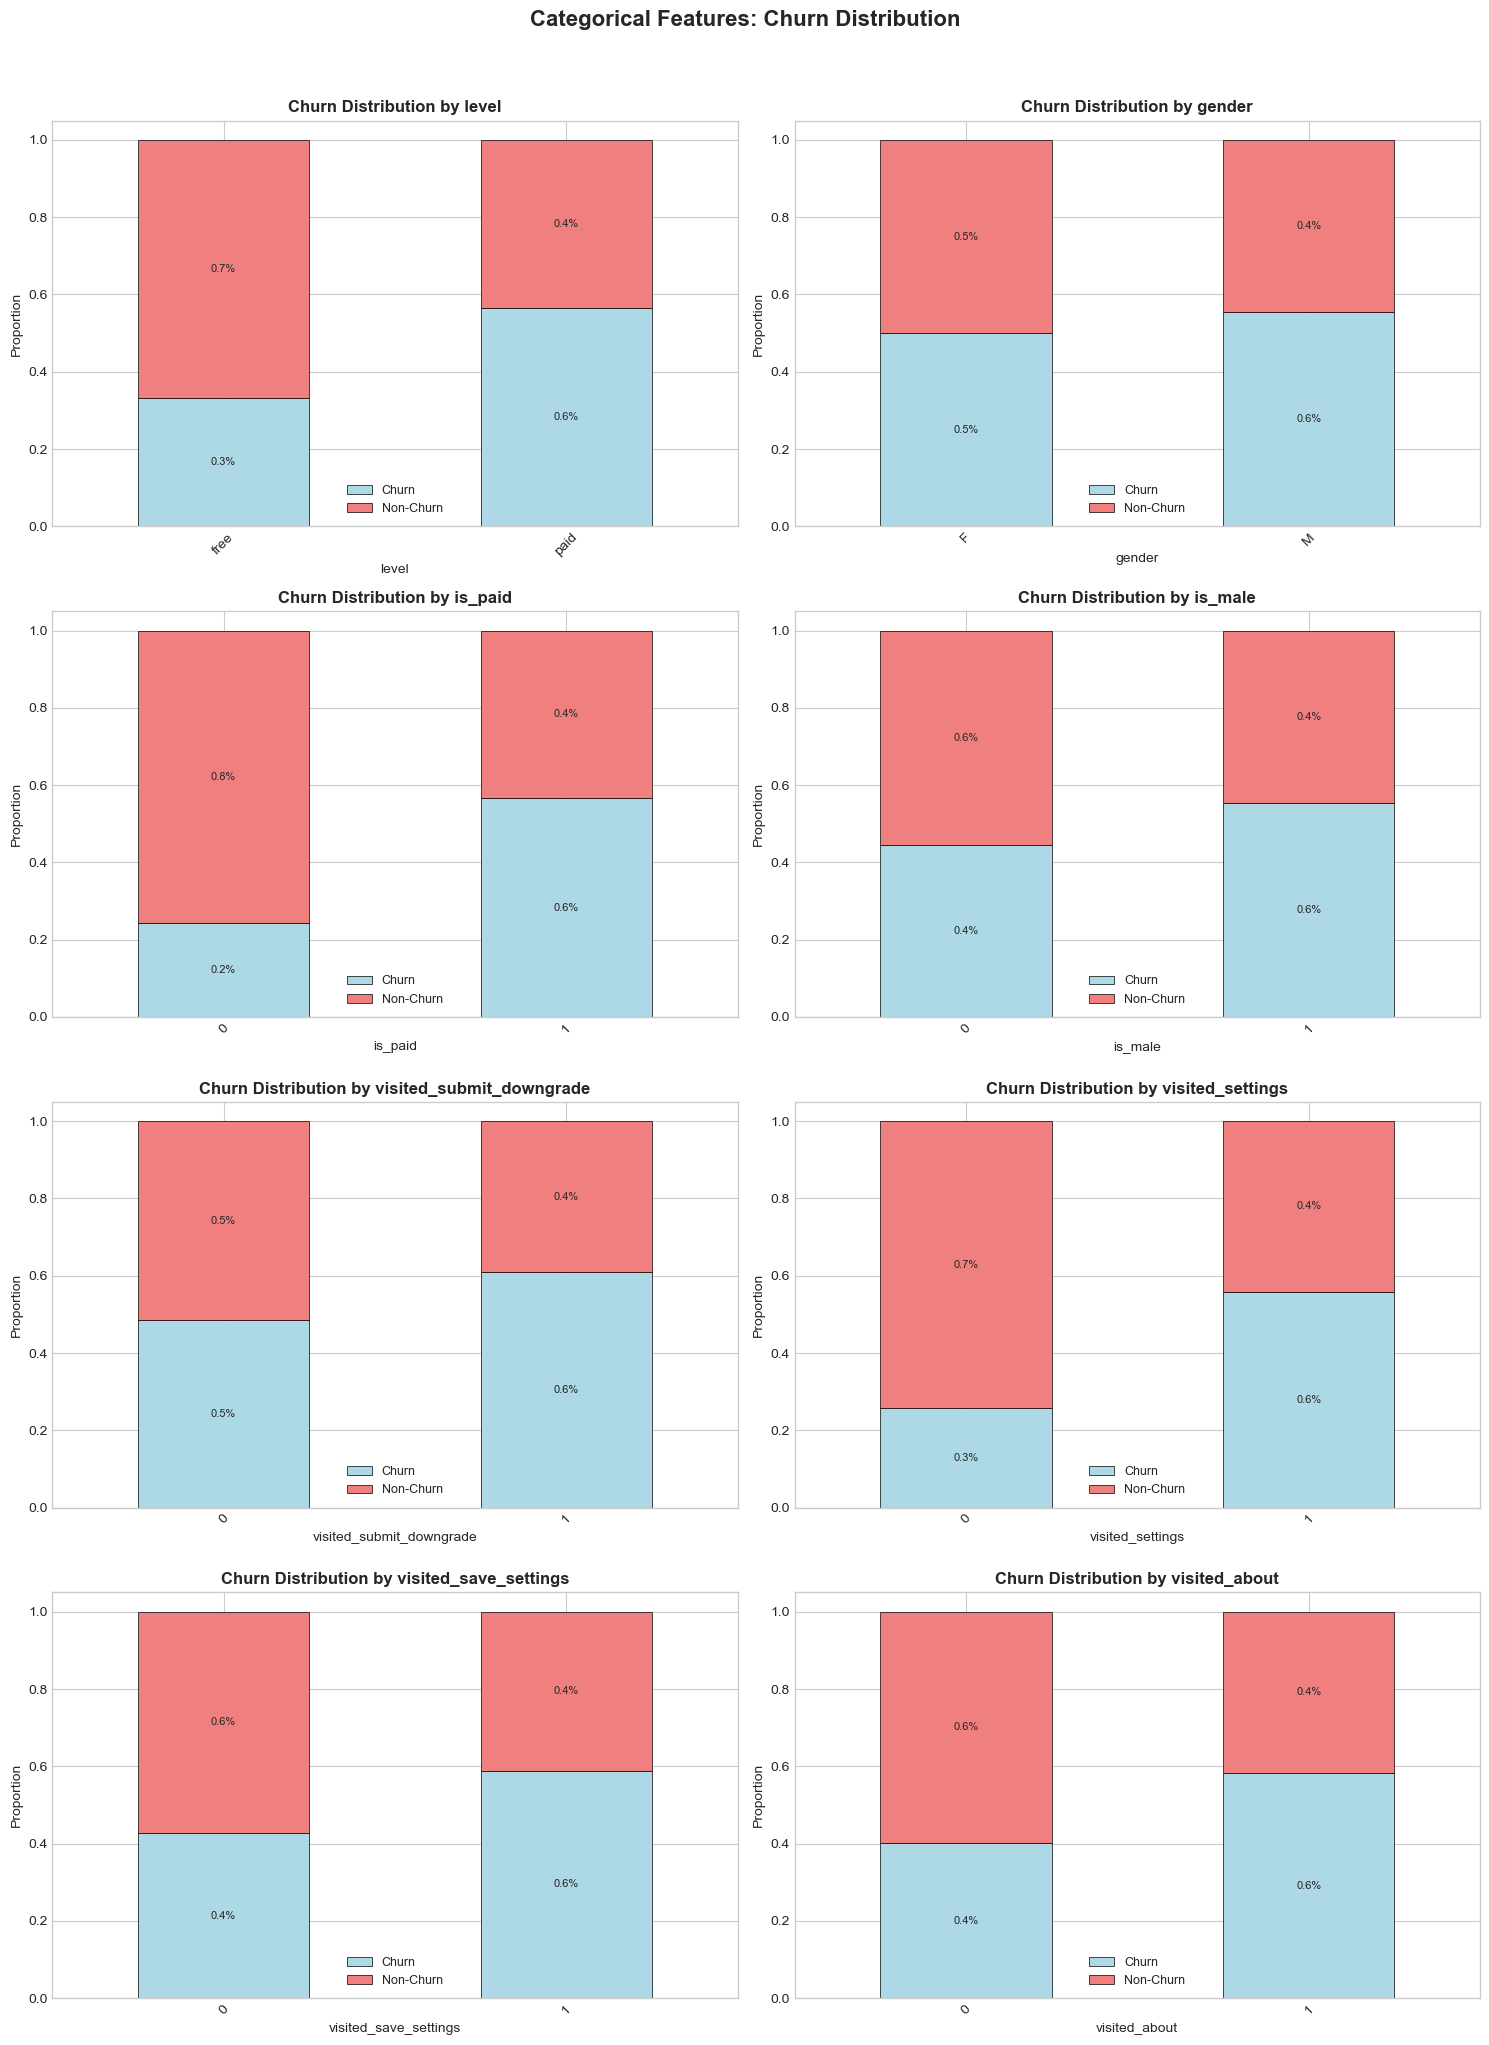


6. SCATTER MATRIX - Relationships Between Top Features


c:\Users\ninaj\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:2842: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


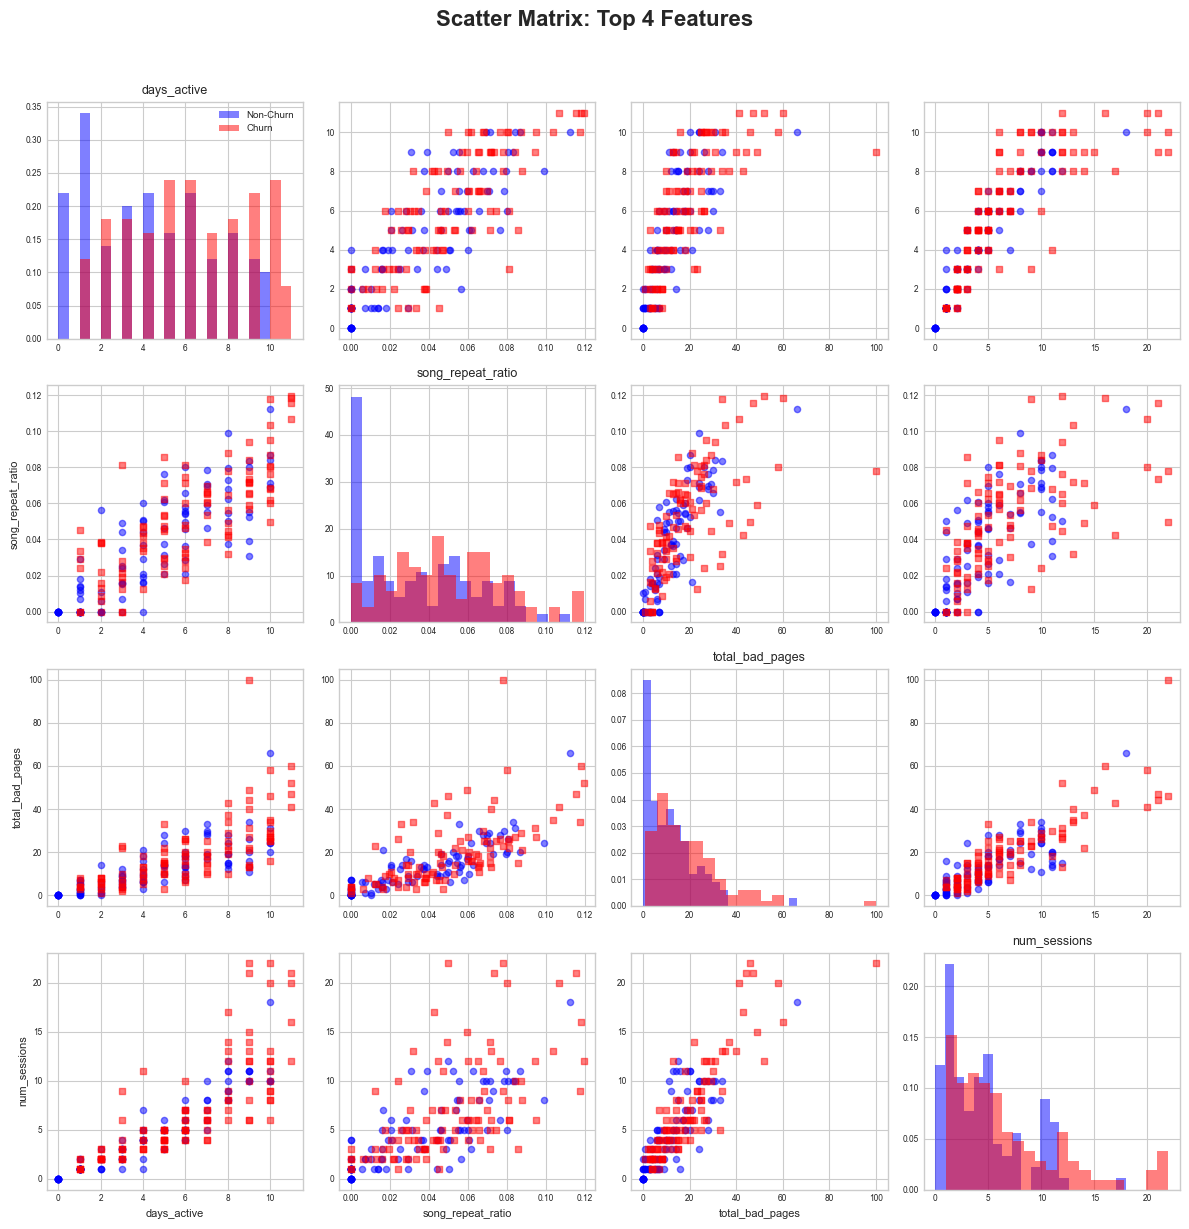

In [34]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

features_df = users_200

if features_df.empty:
    print("ERROR: No features created!")
else:
    print(f"Features shape: {features_df.shape}")
    print(f"Churners: {features_df['churned'].sum()},",
          "Non-churners: {len(features_df) - features_df['churned'].sum()}"
    )

# Convert churned to string for plotting
features_df['churned_str'] = features_df['churned'].map(
    {0: 'Non-Churn', 1: 'Churn'}
)

# 1. DISTRIBUTION PLOTS FOR NUMERIC FEATURES
print("\n" + "="*100)
print("1. DISTRIBUTION PLOTS - Churners vs Non-Churners")
print("="*100)

def plot_feature_distributions(features_df):
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in ['userId', 'churned', 'is_paid', 'is_male', 
                                                                'visited_submit_downgrade', 'visited_settings',
                                                                'visited_save_settings', 'visited_about']]
    
    # Group features by category
    activity_features = [col for col in numeric_cols if any(x in col.lower() for x in ['session', 'song', 'day', 'active', 'event'])]
    page_features = [col for col in numeric_cols if any(x in col.lower() for x in ['count', 'ratio', 'total', 'bad', 'good', 'help'])]
    music_features = [col for col in numeric_cols if any(x in col.lower() for x in ['artist', 'song', 'length', 'concentration', 'repeat'])]
    time_features = [col for col in numeric_cols if any(x in col.lower() for x in ['trend', 'change', 'volatility', 'duration'])]
    
    # Plot each category
    categories = [
        ("Activity Metrics", activity_features[:12]),
        ("Page Visit Metrics", page_features[:12]),
        ("Music Diversity", music_features[:12]),
        ("Time & Trends", time_features[:12])
    ]
    
    for category_name, feature_list in categories:
        if not feature_list:
            continue
            
        print(f"\nPlotting {category_name}...")
        
        n_cols = 3
        n_rows = (len(feature_list) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
        axes = axes.flatten()
        
        for i, feature in enumerate(feature_list):
            if feature not in features_df.columns:
                axes[i].set_visible(False)
                continue
                
            ax = axes[i]
            
            # Remove outliers for better visualization
            data = features_df[[feature, 'churned_str']].dropna()
            if len(data) > 0:
                # Keep 95% of data
                Q1 = data[feature].quantile(0.05)
                Q3 = data[feature].quantile(0.95)
                data = data[(data[feature] >= Q1) & (data[feature] <= Q3)]
            
            # Plot distributions
            for churn_status, color in [('Non-Churn', 'blue'), ('Churn', 'red')]:
                subset = data[data['churned_str'] == churn_status][feature]
                if len(subset) > 0:
                    sns.kdeplot(subset, ax=ax, label=churn_status, color=color, fill=True, alpha=0.5)
            
            ax.set_title(feature, fontsize=11, fontweight='bold')
            ax.set_xlabel('')
            ax.legend(fontsize=9)
            
            # Add mean lines
            for churn_status, color in [('Non-Churn', 'blue'), ('Churn', 'red')]:
                subset = data[data['churned_str'] == churn_status][feature]
                if len(subset) > 0:
                    mean_val = subset.mean()
                    ax.axvline(mean_val, color=color, linestyle='--', alpha=0.7, linewidth=1)
        
        # Hide empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
        
        plt.suptitle(f'{category_name}: Distribution Comparison', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

plot_feature_distributions(features_df)

# 2. BOX PLOTS FOR TOP FEATURES
print("\n" + "="*100)
print("2. BOX PLOTS")
print("="*100)

def plot_boxplots_top_features(features_df, top_n=15):
    # Calculate mean difference between churners and non-churners
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != 'churned']
    
    mean_diffs = {}
    for col in numeric_cols:
        if col in features_df.columns:
            non_churn_mean = features_df[features_df['churned'] == 0][col].mean()
            churn_mean = features_df[features_df['churned'] == 1][col].mean()
            mean_diffs[col] = abs(churn_mean - non_churn_mean)
    
    # Get top features by mean difference
    top_features = sorted(mean_diffs.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_features = [f[0] for f in top_features]
    
    n_cols = 3
    n_rows = (len(top_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
    axes = axes.flatten()
    
    for i, feature in enumerate(top_features):
        ax = axes[i]
        
        # Create boxplot with string labels
        sns.boxplot(x='churned_str', y=feature, data=features_df, ax=ax,
                   palette={'Non-Churn': 'lightblue', 'Churn': 'lightcoral'}, showfliers=False)
        
        # Add swarm plot to show individual points
        sns.swarmplot(x='churned_str', y=feature, data=features_df, ax=ax,
                     size=2, color='black', alpha=0.3)
        
        # Calculate and display difference
        non_churn_median = features_df[features_df['churned'] == 0][feature].median()
        churn_median = features_df[features_df['churned'] == 1][feature].median()
        diff_pct = ((churn_median - non_churn_median) / non_churn_median * 100) if non_churn_median != 0 else 0
        
        ax.set_title(f'{feature}\nDiff: {diff_pct:+.1f}%', fontsize=11, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # Color the title based on direction
        title_color = 'red' if diff_pct > 10 else 'orange' if diff_pct > 5 else 'green'
        ax.title.set_color(title_color)
    
    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Boxplots: Top Features by Difference Between Churners and Non-Churners', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return top_features

top_features = plot_boxplots_top_features(features_df)

# 3. CATEGORICAL FEATURES BAR PLOTS
print("\n" + "="*100)
print("3. CATEGORICAL FEATURES - Bar Charts")
print("="*100)

def plot_categorical_features(features_df):
    """Plot categorical features"""
    categorical_cols = ['level', 'gender', 'is_paid', 'is_male',
                       'visited_submit_downgrade', 'visited_settings',
                       'visited_save_settings', 'visited_about']
    
    # Filter to columns that exist
    categorical_cols = [col for col in categorical_cols if col in features_df.columns]
    
    if not categorical_cols:
        print("No categorical features found!")
        return
    
    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten()
    
    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        
        # Create cross-tabulation
        cross_tab = pd.crosstab(features_df[col], features_df['churned_str'], normalize='index')
        
        # Plot stacked bar chart
        cross_tab.plot(kind='bar', stacked=True, ax=ax, 
                      color=['lightblue', 'lightcoral'], edgecolor='black', linewidth=0.5)
        
        ax.set_title(f'Churn Distribution by {col}', fontsize=12, fontweight='bold')
        ax.set_xlabel(col, fontsize=10)
        ax.set_ylabel('Proportion', fontsize=10)
        ax.legend(fontsize=9)
        ax.tick_params(axis='x', rotation=45)
        
        # Add percentages on bars
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=8)
    
    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Categorical Features: Churn Distribution', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

plot_categorical_features(features_df)


# 4. SCATTER MATRIX FOR TOP FEATURES
print("\n" + "="*100)
print("6. SCATTER MATRIX - Relationships Between Top Features")
print("="*100)

def plot_scatter_matrix(features_df, n_features=6):
    # Get top features by correlation
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
    correlations = {}
    for col in numeric_cols:
        if col != 'churned' and col in features_df.columns:
            corr = features_df[col].corr(features_df['churned'])
            if not pd.isna(corr):
                correlations[col] = abs(corr)
    
    top_features = sorted(correlations.items(), key=lambda x: x[1], reverse=True)[:n_features]
    top_features = [f[0] for f in top_features]
    
    # Create pairplot
    plot_data = features_df[top_features + ['churned_str']].dropna()
    
    # Create custom grid
    n_cols = n_features
    n_rows = n_features
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]
            
            if i == j:
                # Diagonal: Histogram
                feature = top_features[i]
                for churn_status, color in [('Non-Churn', 'blue'), ('Churn', 'red')]:
                    subset = plot_data[plot_data['churned_str'] == churn_status][feature]
                    ax.hist(subset, alpha=0.5, color=color, label=churn_status, bins=20, density=True)
                ax.set_title(feature, fontsize=9)
                if i == 0 and j == 0:
                    ax.legend(fontsize=7)
            else:
                # Off-diagonal: Scatter plot
                x_feature = top_features[j]
                y_feature = top_features[i]
                
                for churn_status, color, marker in [('Non-Churn', 'blue', 'o'), ('Churn', 'red', 's')]:
                    subset = plot_data[plot_data['churned_str'] == churn_status]
                    ax.scatter(subset[x_feature], subset[y_feature], alpha=0.5, 
                              color=color, marker=marker, s=20, label=churn_status)
                
                if i == n_rows - 1:
                    ax.set_xlabel(x_feature, fontsize=8)
                if j == 0:
                    ax.set_ylabel(y_feature, fontsize=8)
            
            ax.tick_params(labelsize=6)
    
    plt.suptitle(f'Scatter Matrix: Top {n_features} Features', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Only plot if we have enough data
if len(features_df) > 10:
    plot_scatter_matrix(features_df, n_features=4)

In [42]:
def analyze_daily_features(user_id):
    """
    Analyze features for EACH DAY in the 10-day window
    Returns DataFrame where each row is one day
    """
    user_data = quick_analysis(user_id)
    
    if len(user_data) == 0:
        return pd.DataFrame()
    
    # Group by day
    user_data = user_data.sort_values('time')
    user_data['date'] = user_data['time'].dt.date
    
    daily_results = []
    
    for date, day_data in user_data.groupby('date'):
        if len(day_data) == 0:
            continue
            
        # Get day number (0 = churn day, 1 = 1 day before churn, etc.)
        if 'days_before_churn' in day_data.columns:
            day_num = day_data['days_before_churn'].iloc[0]
        else:
            # Estimate from date
            reference_date = day_data['reference_date'].iloc[0] if 'reference_date' in day_data.columns else day_data['time'].max()
            day_num = (reference_date.date() - date).days
        
        # Basic daily metrics
        daily_metrics = {
            'userId': user_id,
            'date': date,
            'day_before_churn': day_num,
            'churned': day_data['churned'].iloc[0] if 'churned' in day_data.columns else 0,
            
            # Activity metrics for this day
            'daily_sessions': day_data['sessionId'].nunique(),
            'daily_songs_played': (day_data['page'] == 'NextSong').sum(),
            'daily_events': len(day_data),
            
            # Page visits for this day
            'daily_thumbs_up': (day_data['page'] == 'Thumbs Up').sum(),
            'daily_thumbs_down': (day_data['page'] == 'Thumbs Down').sum(),
            'daily_add_friend': (day_data['page'] == 'Add Friend').sum(),
            'daily_add_to_playlist': (day_data['page'] == 'Add to Playlist').sum(),
            'daily_roll_advert': (day_data['page'] == 'Roll Advert').sum(),
            'daily_error': (day_data['page'] == 'Error').sum(),
            'daily_help': (day_data['page'] == 'Help').sum(),
            
            # Session metrics for this day
            'avg_session_duration_day': 0,
            'avg_songs_per_session_day': 0,
        }
        
        # Calculate session metrics for this day
        if daily_metrics['daily_sessions'] > 0:
            session_durations = []
            songs_per_session = []
            
            for session_id, session_data in day_data.groupby('sessionId'):
                # Session duration
                session_start = session_data['time'].min()
                session_end = session_data['time'].max()
                session_duration = (session_end - session_start).total_seconds()
                session_durations.append(session_duration)
                
                # Songs per session
                songs_in_session = (session_data['page'] == 'NextSong').sum()
                songs_per_session.append(songs_in_session)
            
            if session_durations:
                daily_metrics['avg_session_duration_day'] = np.mean(session_durations)
            
            if songs_per_session:
                daily_metrics['avg_songs_per_session_day'] = np.mean(songs_per_session)
        
        # Music diversity for this day
        song_plays = day_data[day_data['page'] == 'NextSong']
        if len(song_plays) > 0:
            daily_metrics['daily_unique_artists'] = song_plays['artist'].nunique()
            daily_metrics['daily_unique_songs'] = song_plays['song'].nunique()
            daily_metrics['daily_avg_song_length'] = song_plays['length'].mean()
        else:
            daily_metrics['daily_unique_artists'] = 0
            daily_metrics['daily_unique_songs'] = 0
            daily_metrics['daily_avg_song_length'] = 0
        
        # Bad/good page ratios
        daily_metrics['daily_thumbs_ratio'] = (
            daily_metrics['daily_thumbs_down'] / daily_metrics['daily_thumbs_up'] 
            if daily_metrics['daily_thumbs_up'] > 0 else 0
        )
        
        daily_metrics['daily_bad_pages'] = day_data['page'].isin(bad_pages).sum()
        daily_metrics['daily_good_pages'] = day_data['page'].isin(good_pages).sum()
        
        
        daily_results.append(daily_metrics)
    
    return pd.DataFrame(daily_results)

def analyze_multiple_users_daily(n_churners=10, n_non_churners=10):
    """
    Analyze daily features for multiple users
    """
    churner_ids = churned_users[:n_churners]
    non_churner_ids = non_churn_users[:n_non_churners]
    user_ids = list(churner_ids) + list(non_churner_ids)
    
    all_daily_features = []
    
    for i, user_id in enumerate(user_ids):        
        daily_df = analyze_daily_features(user_id)
        
        if not daily_df.empty:
            # Add user-level info
            daily_df['is_churner'] = 1 if user_id in churner_ids else 0
            all_daily_features.append(daily_df)
    

    combined_df = pd.concat(all_daily_features, ignore_index=True)
    return combined_df


daily_features = analyze_multiple_users_daily(n_churners=20, n_non_churners=20)

In [41]:
daily_features



DAILY TREND VISUALIZATIONS


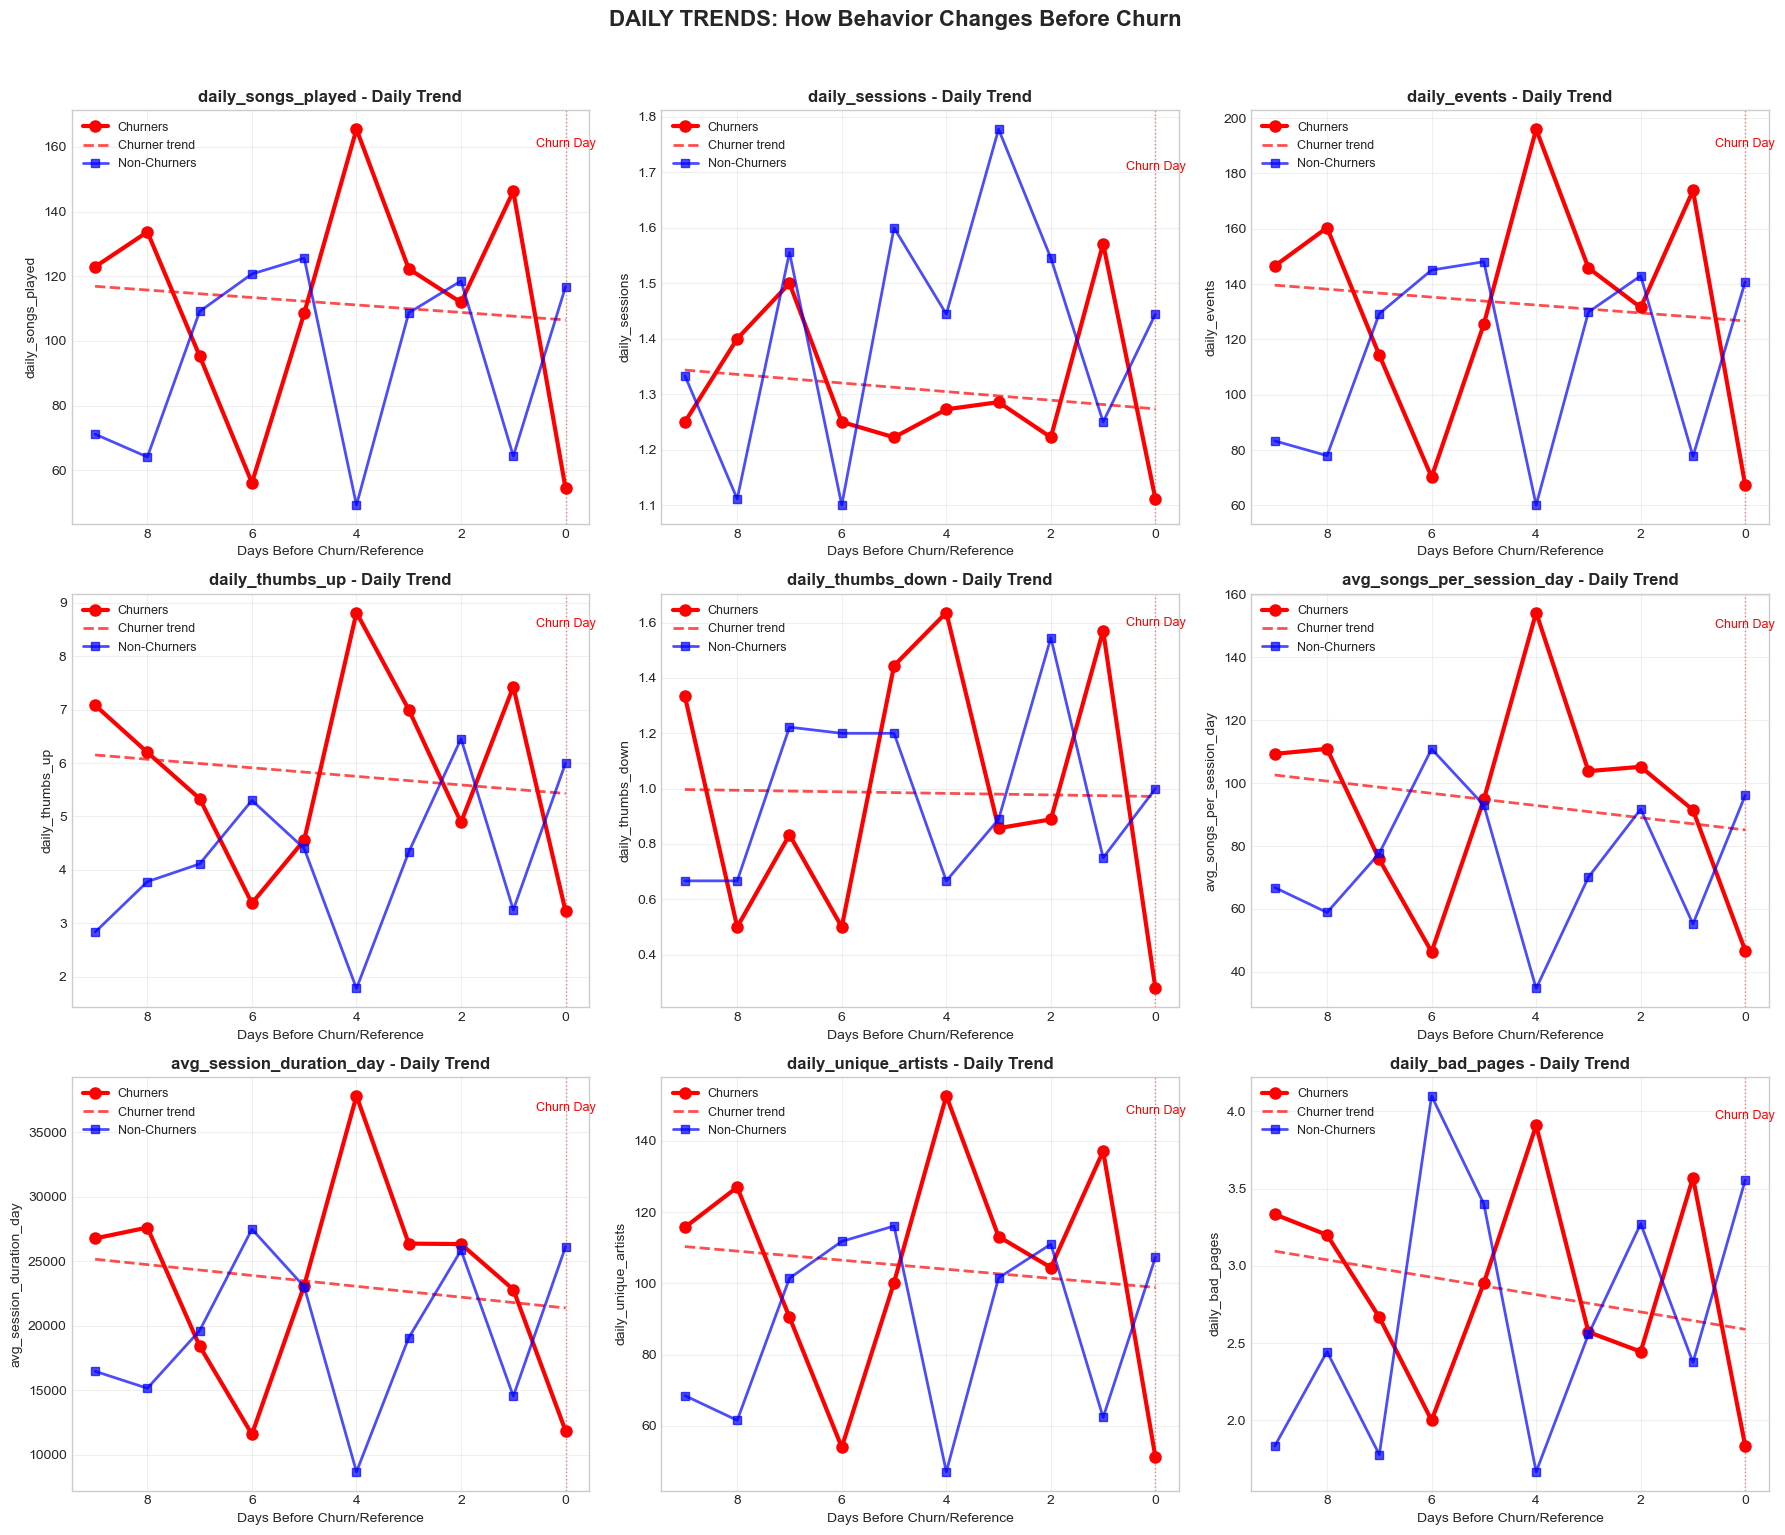

In [43]:
def plot_daily_trends(daily_features):
    """
    Plot how features change day by day before churn
    """
    if daily_features.empty:
        print("No daily data to plot!")
        return
    
    # Filter to users with at least 5 days of data
    user_day_counts = daily_features.groupby('userId').size()
    valid_users = user_day_counts[user_day_counts >= 5].index
    plot_data = daily_features[daily_features['userId'].isin(valid_users)].copy()
    
    # Key metrics to plot
    metrics_to_plot = [
        'daily_songs_played',
        'daily_sessions',
        'daily_events',
        'daily_thumbs_up',
        'daily_thumbs_down',
        'avg_songs_per_session_day',
        'avg_session_duration_day',
        'daily_unique_artists',
        'daily_bad_pages'
    ]
    
    # Only keep metrics that exist
    metrics_to_plot = [m for m in metrics_to_plot if m in plot_data.columns]
    
    n_cols = 3
    n_rows = (len(metrics_to_plot) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        
        # Separate churners and non-churners
        churner_data = plot_data[plot_data['is_churner'] == 1]
        non_churner_data = plot_data[plot_data['is_churner'] == 0]
        
        # Plot churners with days before churn
        if not churner_data.empty:
            # Get average by day_before_churn
            churn_avg = churner_data.groupby('day_before_churn')[metric].mean().reset_index()
            churn_avg = churn_avg.sort_values('day_before_churn', ascending=False)  # Day 10 → Day 0
            
            ax.plot(churn_avg['day_before_churn'], churn_avg[metric], 
                   color='red', linewidth=3, marker='o', markersize=8, label='Churners')
            
            # Add trend line for churners
            if len(churn_avg) > 1:
                z = np.polyfit(churn_avg['day_before_churn'], churn_avg[metric], 1)
                p = np.poly1d(z)
                ax.plot(churn_avg['day_before_churn'], p(churn_avg['day_before_churn']), 
                       'r--', alpha=0.7, linewidth=2, label='Churner trend')
        
        # Plot non-churners (use relative days)
        if not non_churner_data.empty:
            # For non-churners, align by last day
            non_churn_avg = non_churner_data.groupby('day_before_churn')[metric].mean().reset_index()
            non_churn_avg = non_churn_avg.sort_values('day_before_churn', ascending=False)
            
            ax.plot(non_churn_avg['day_before_churn'], non_churn_avg[metric],
                   color='blue', linewidth=2, marker='s', markersize=6, label='Non-Churners', alpha=0.7)
        
        ax.set_title(f'{metric} - Daily Trend', fontsize=12, fontweight='bold')
        ax.set_xlabel('Days Before Churn/Reference', fontsize=10)
        ax.set_ylabel(metric, fontsize=10)
        ax.invert_xaxis()  # So day 10 is left, day 0 is right
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Add day 0 marker (churn day)
        ax.axvline(x=0, color='red', linestyle=':', alpha=0.5, linewidth=1)
        ax.text(0, ax.get_ylim()[1] * 0.95, 'Churn Day', color='red', 
               fontsize=9, ha='center', va='top')
    
    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('DAILY TRENDS: How Behavior Changes Before Churn', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Plot daily trends
print("\n" + "="*100)
print("DAILY TREND VISUALIZATIONS")
print("="*100)
plot_daily_trends(daily_features)